# A2C 仕様変更の確認

<div class="notebook-data">
<div class="author">Ogawa</div>
<div class="company">GRID</div>
<div class="date">2019/1/31</div>
<div class="description">
</div>
</div>

## Conclusion

DDQN logger successful.

In [1]:
import numpy as np
import gym
import copy
import renom as rm
from renom_rl.discrete.a2c import A2C
from old.a2c import A2C as A2C_old
from renom_rl.environ.env import BaseEnv
from tqdm import tqdm
from renom_rl.utility import Animation

In [2]:
env=gym.make("CartPole-v0")

# from renom_rl.utility.structure import ActorCriticModelA3C

class ActorCritic(rm.Model):
    def __init__(self):
        self.l1=rm.Dense(32)
        self.r1=rm.Relu()
        self.l2=rm.Dense(32)
        self.r2=rm.Relu()
        self.l3=rm.Dense(2)
        self.l4=rm.Dense(1)
        
    def forward(self,x):
        h = self.l1(x)
        h = self.r1(h)
        h = self.l2(h)
        h = self.r2(h)
        act = rm.softmax(self.l3(h))
        val=self.l4(h)
        return act,val

model=ActorCritic()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/mikeogawa/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Users/mikeogawa/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [3]:
class CustomEnv(BaseEnv):
    def __init__(self,env):
        self.env = env
        self.action_shape = (2,)
        self.state_shape = (4,)
        self.continous_step = 0
        self.animation=Animation()
        self.test=False

    def sample(self):
        return self.env.action_space.sample()

    def step(self, action):
        state, _ , terminal,_ = self.env.step(action)
        
        reward=0
        self.continous_step += 1
        
        if terminal:
            if self.continous_step > 195:
                reward=1
            else:
                reward=-1
            
            self.continous_step = 0
        
        return state, reward, terminal
    
    def test_start(self):
        if self.test:
            self.animation.reset()
            self.env.reset()

    def test_epoch_step(self):
        if self.test:
            self.animation.store(self.env.render(mode="rgb_array"))

    def test_close(self):
        if self.test:
            self.env.close()
            self.env.viewer=None
 
    def reset_anime(self):
        self.animation.reset()
    
    def reset(self):
        return self.env.reset()

In [4]:
from copy import deepcopy
Env=CustomEnv(env)
a2c=A2C(Env,model)

model2 = deepcopy(model)
Env2=CustomEnv(deepcopy(env))
a2c_old=A2C_old(Env2,model2)

In [5]:
a2c.fit(
    epoch=1,
    epoch_step=10000)

epoch 001 avg_loss:1.0014 total reward in epoch: [train:-96.000 test: 1.0] avg train reward per episode:-0.768: 100%|██████████| 10000/10000 [00:33<00:00, 301.74it/s]


In [6]:
a2c_old.fit(
    epoch=1,
    epoch_step=10000)

epoch 001 avg_loss:-0.0091 total reward in epoch: [train:-654.000 test: 1.0] avg train reward in episode:-81.750: 100%|██████████| 10000/10000 [00:32<00:00, 304.66it/s]


In [7]:
Env.test=True
a2c.test()

1.0

In [8]:
Env2.test=True
a2c_old.test()

1.0


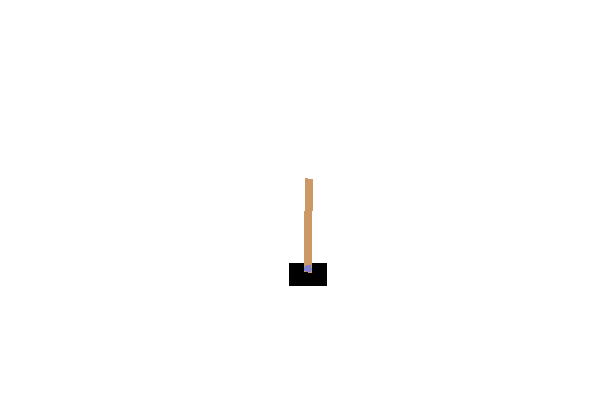
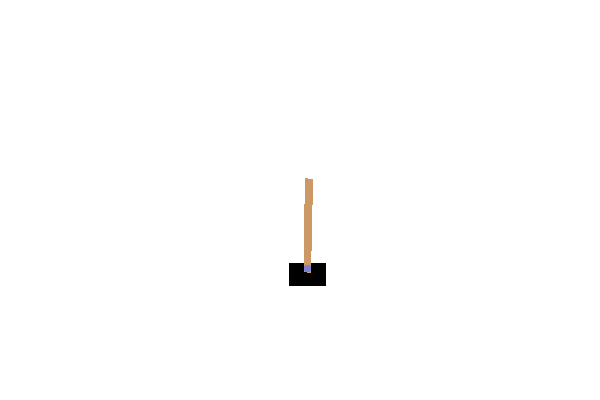
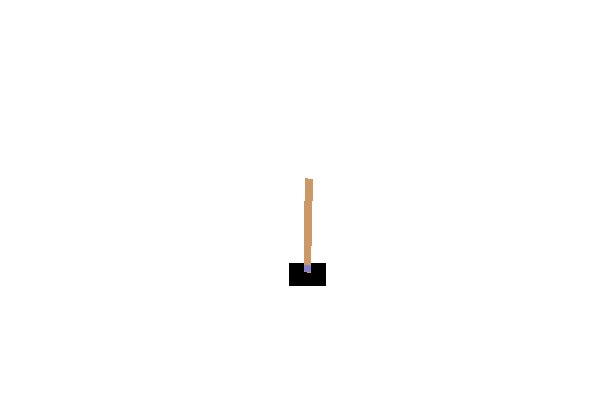
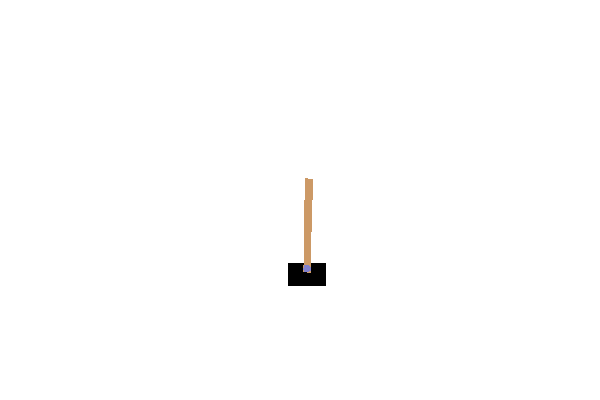
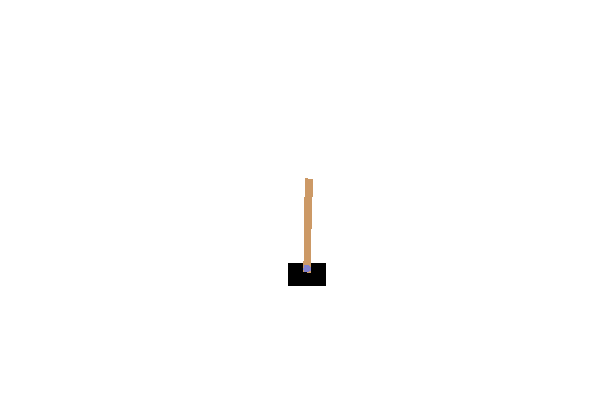
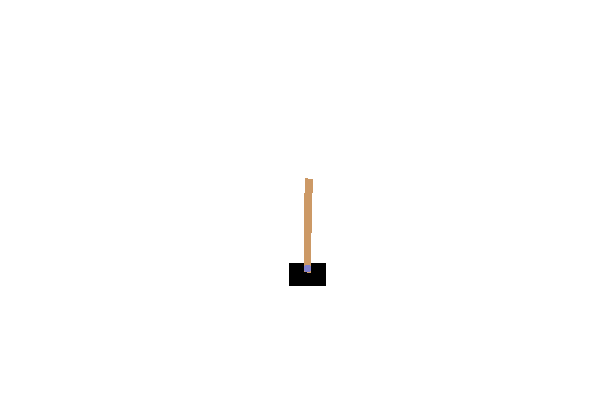
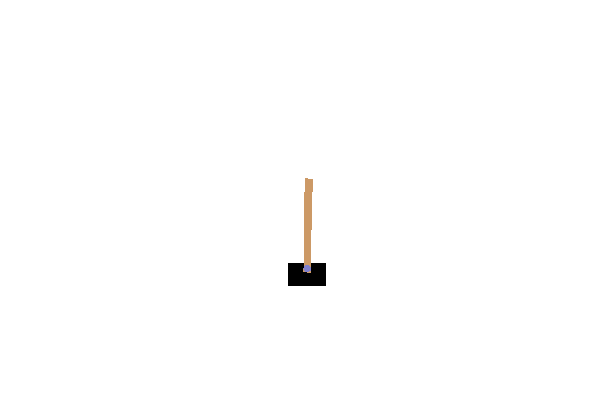
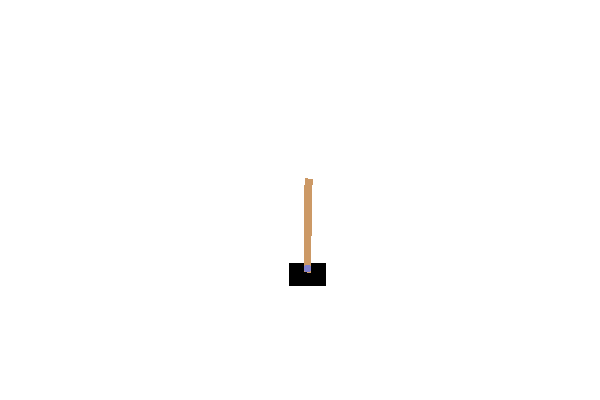
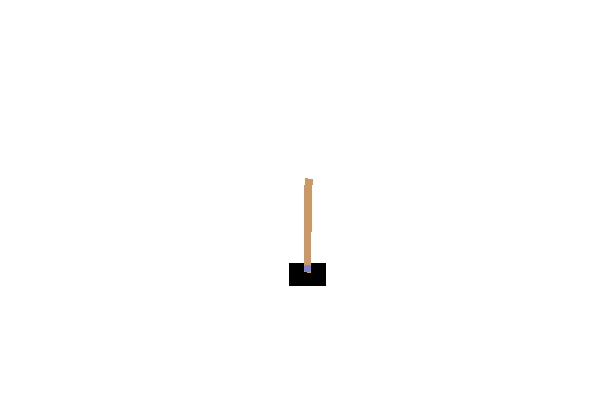
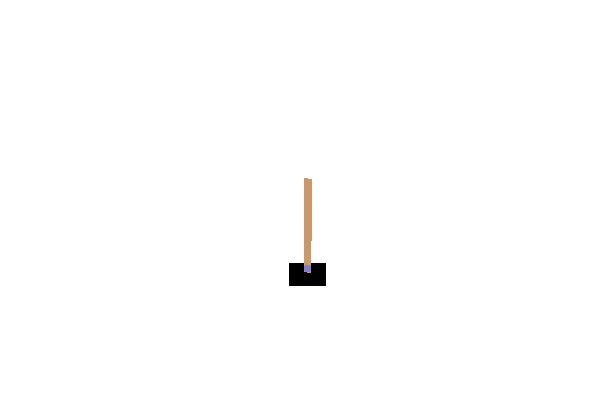
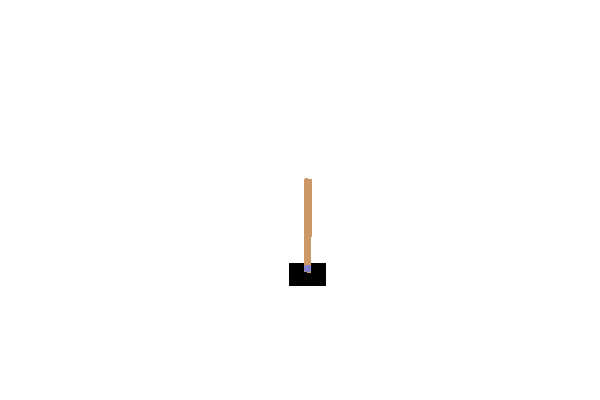
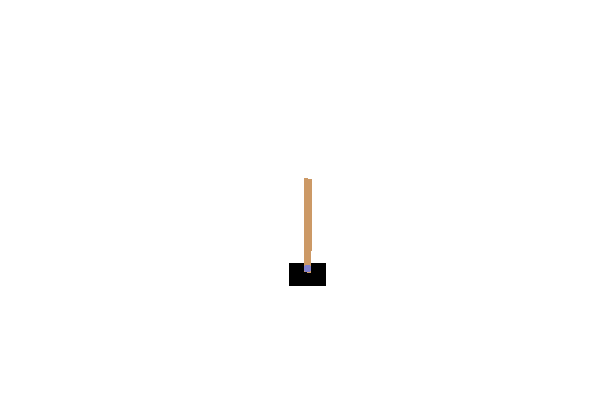
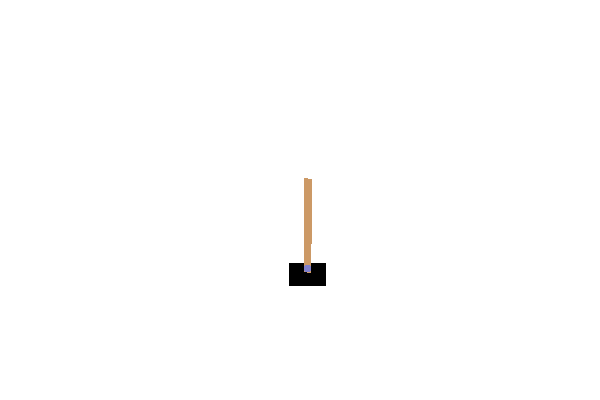
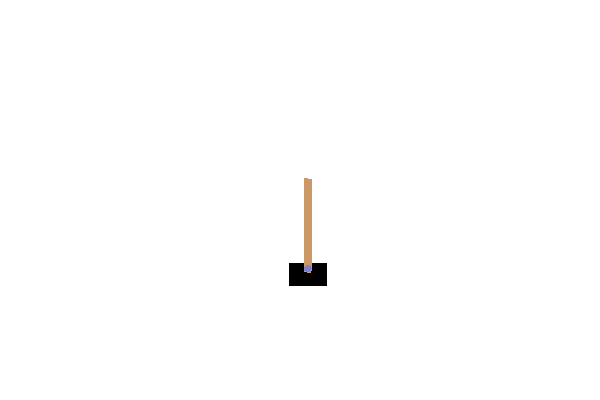
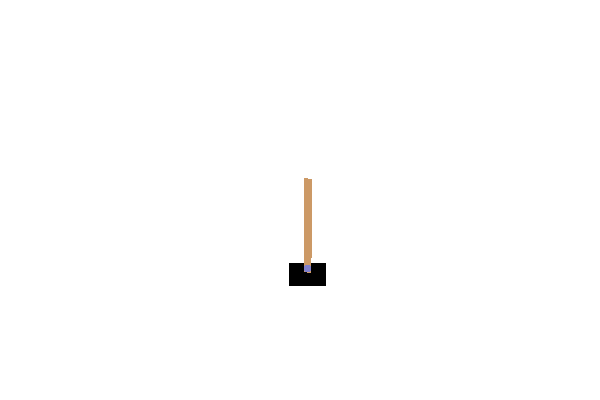
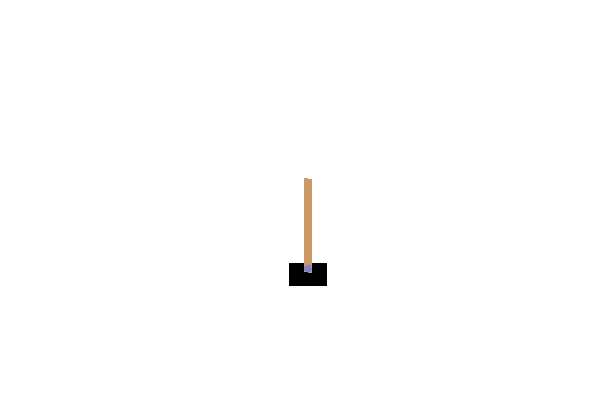
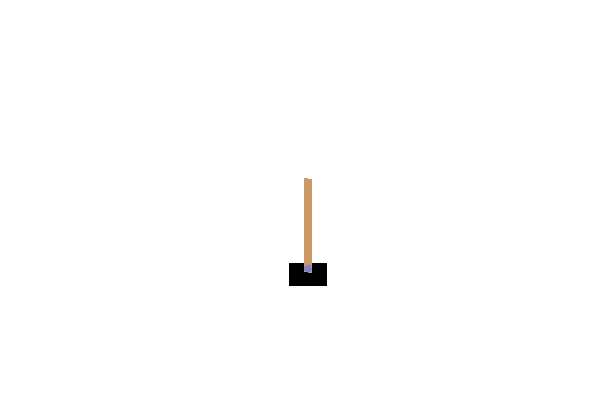
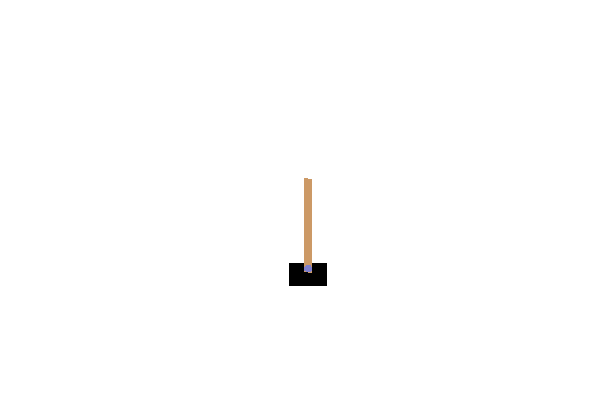
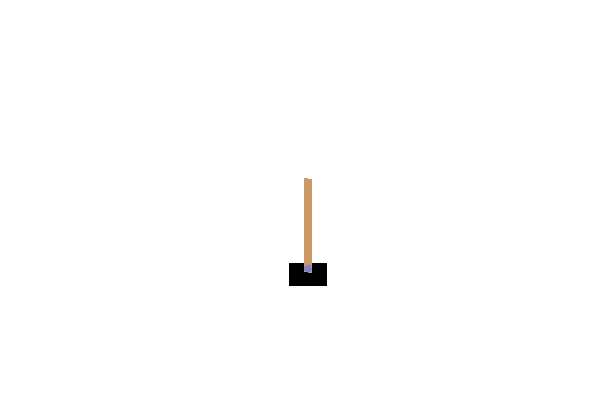
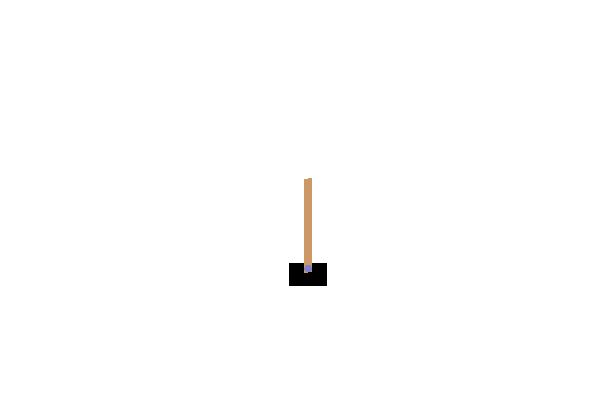
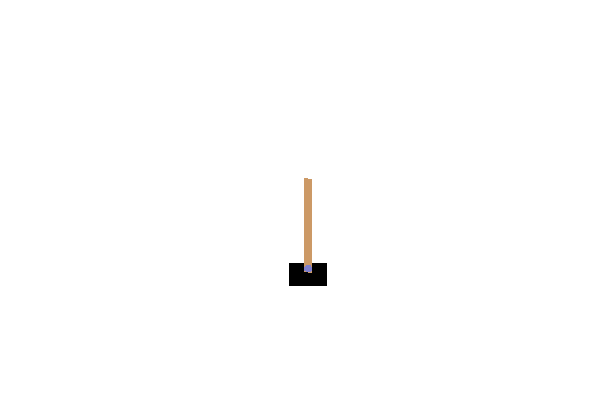
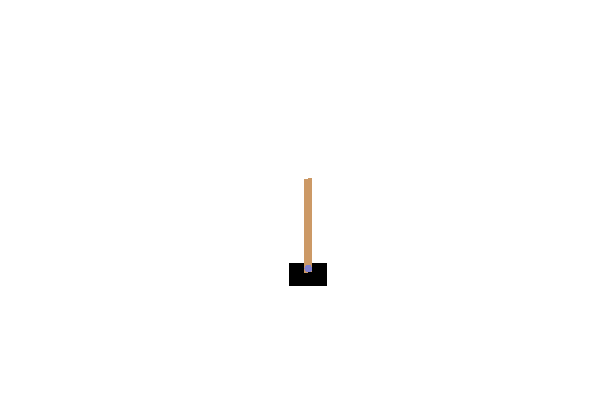
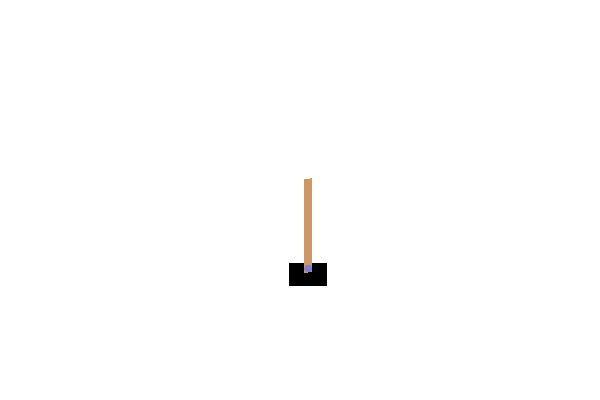
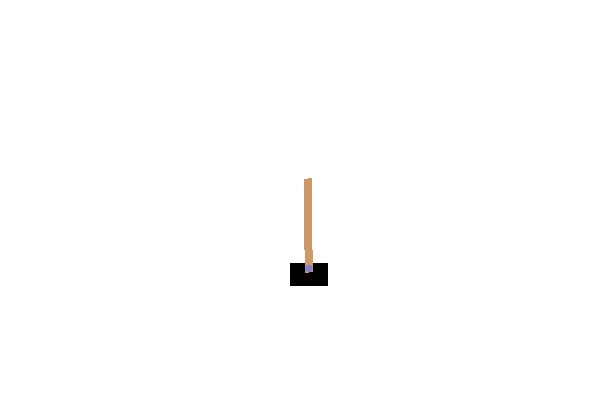
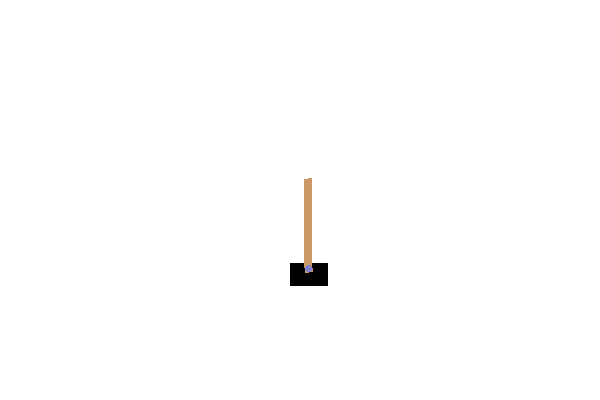
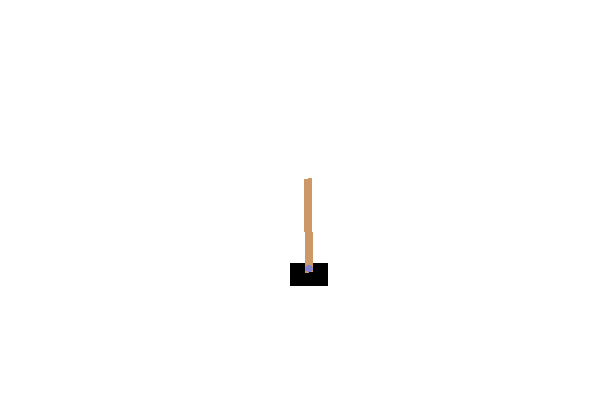
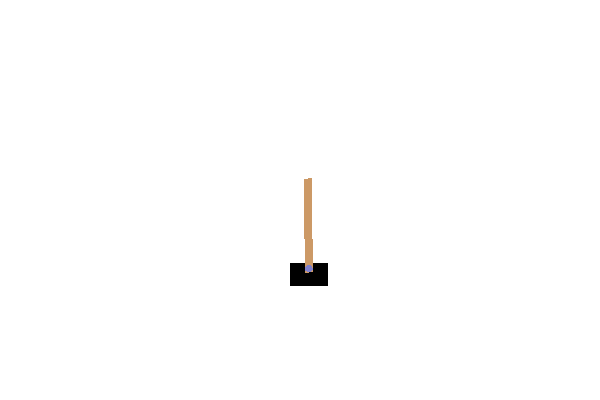
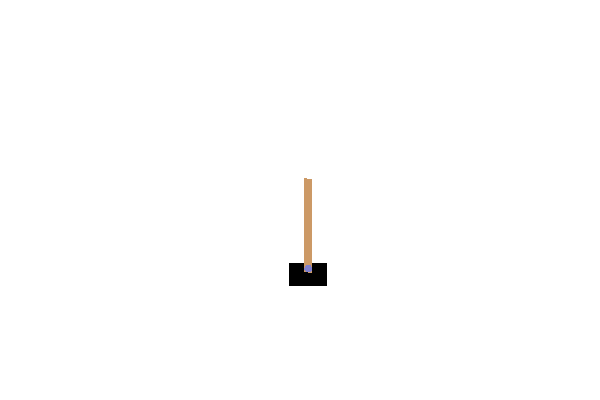
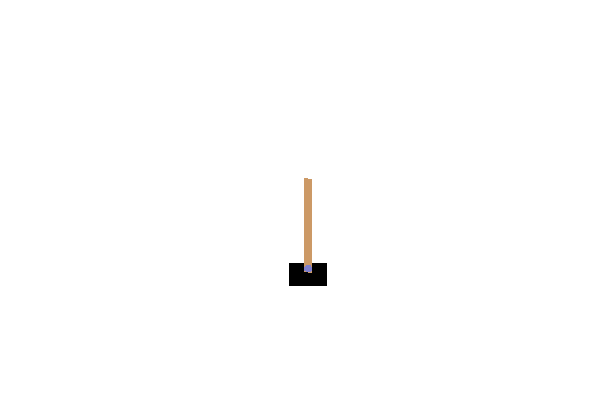
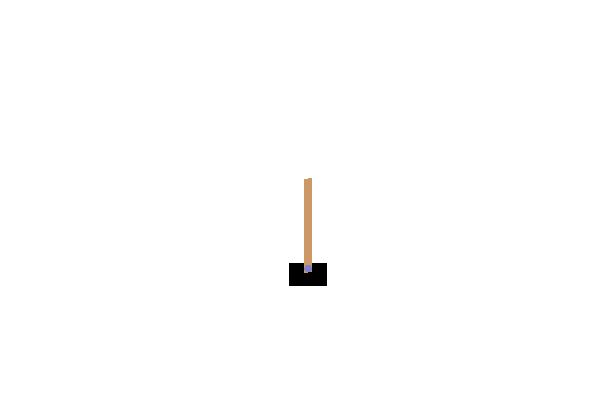
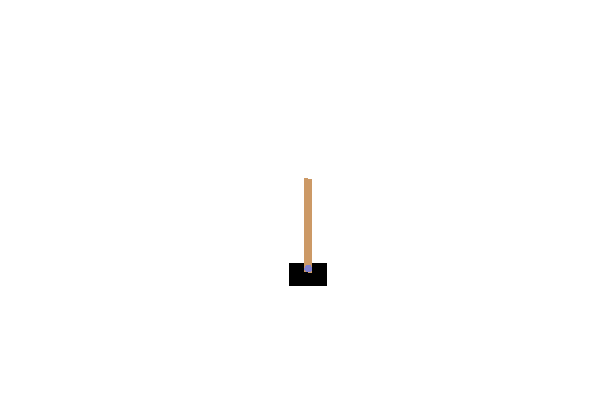
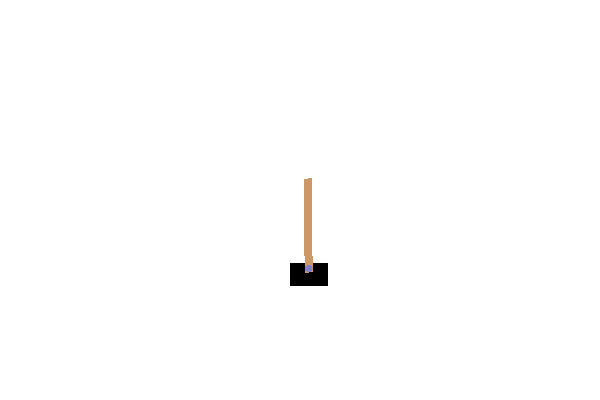
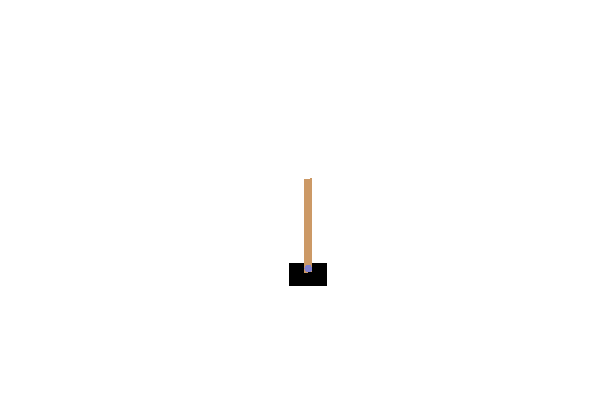
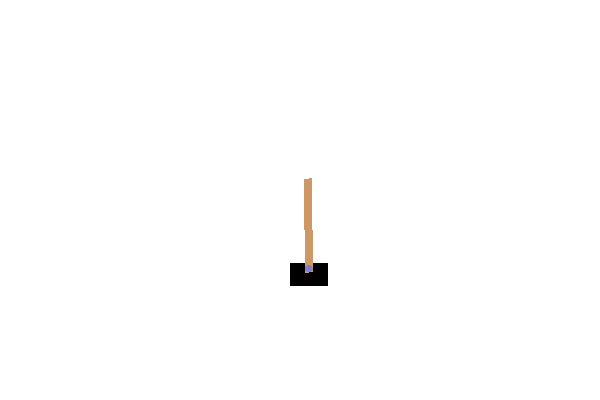
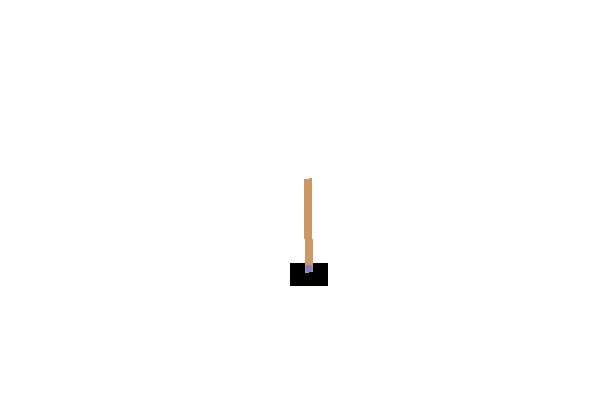
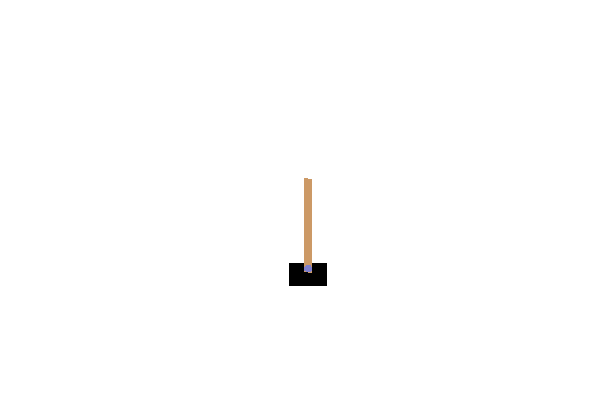
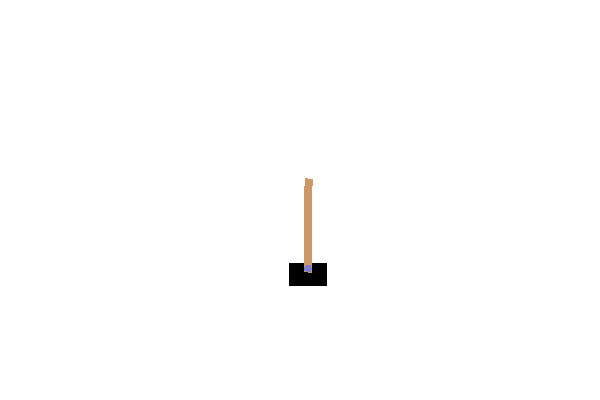
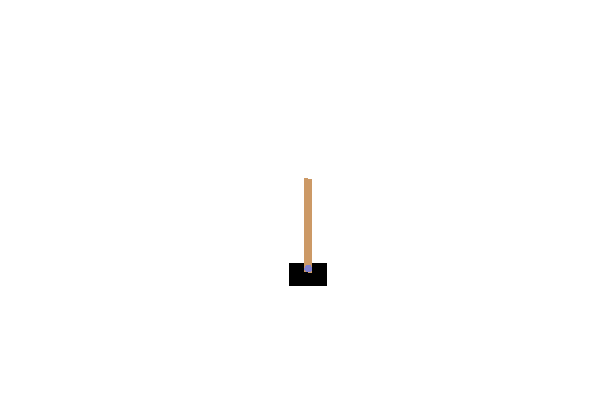
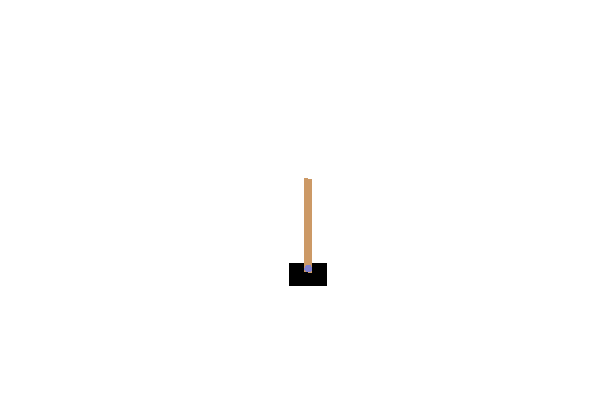
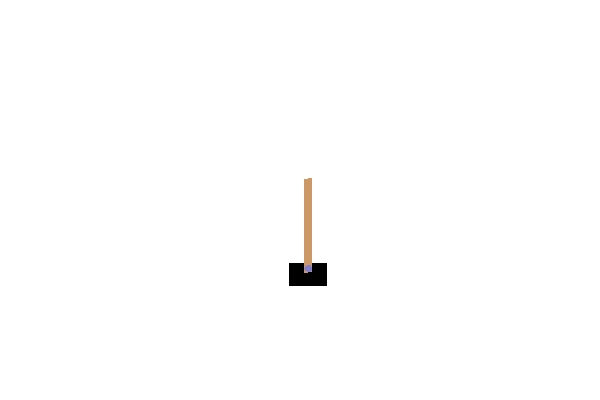
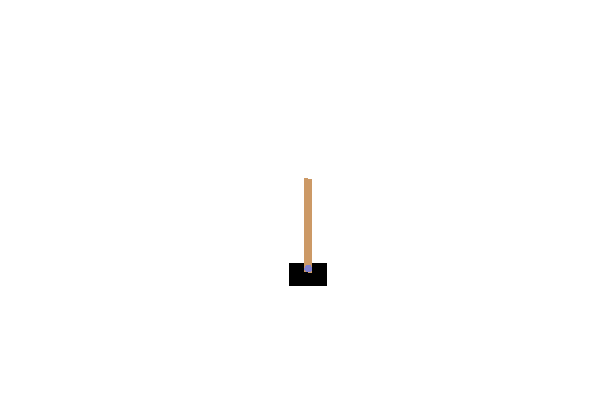
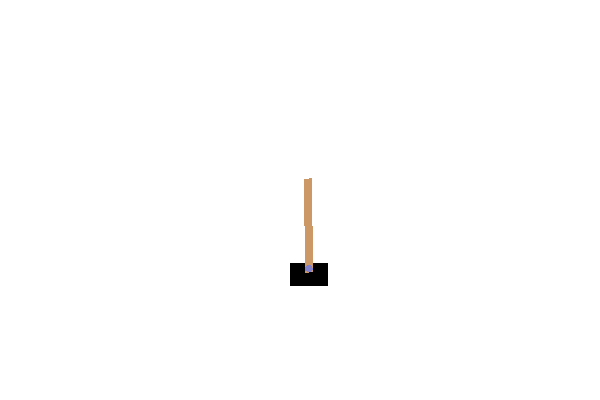
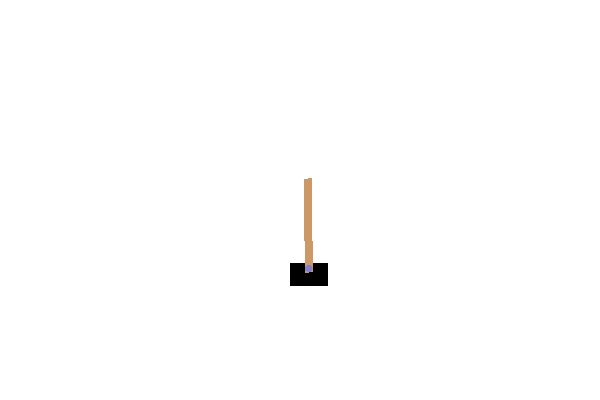
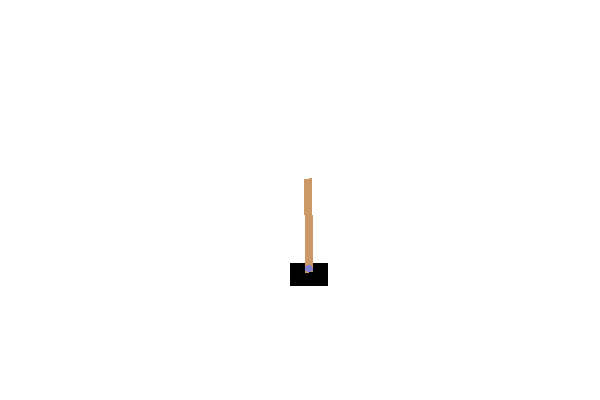
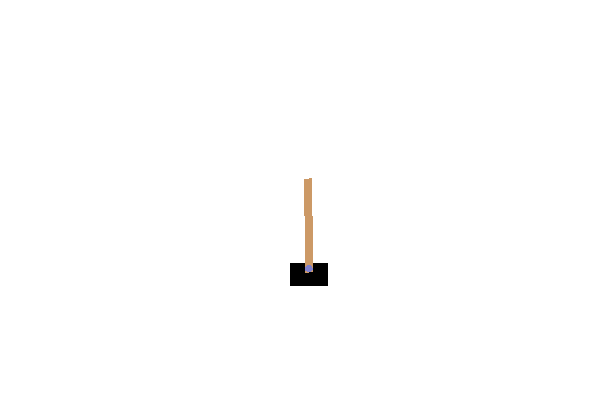
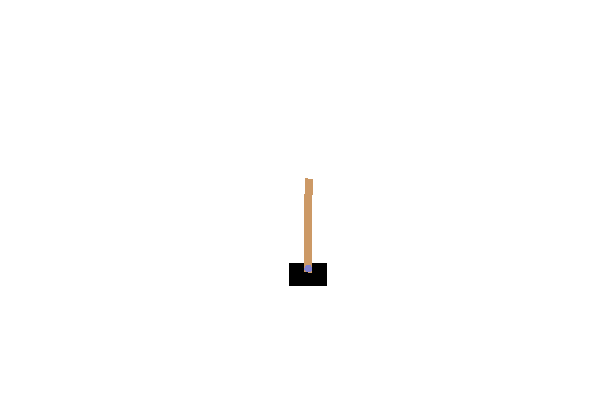
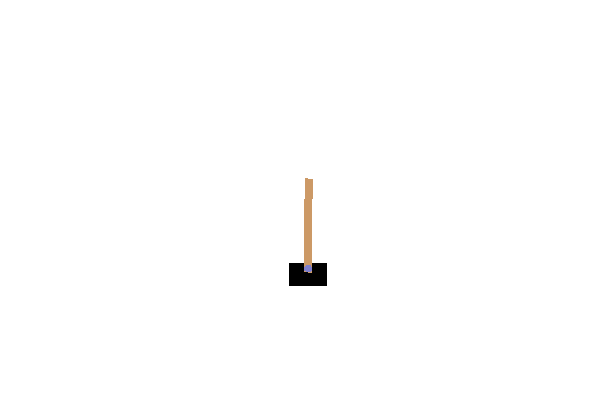
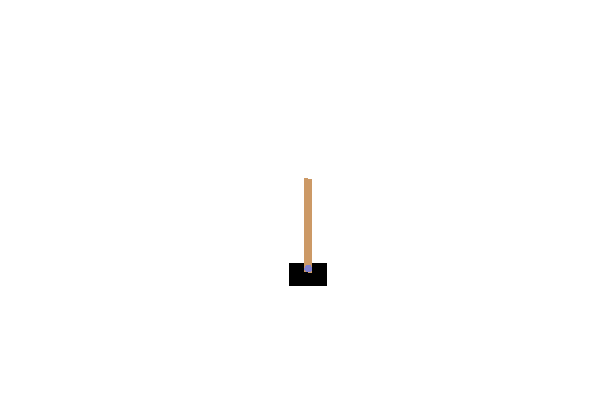
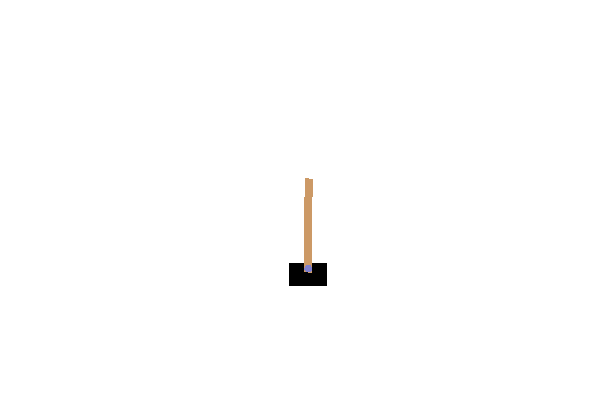
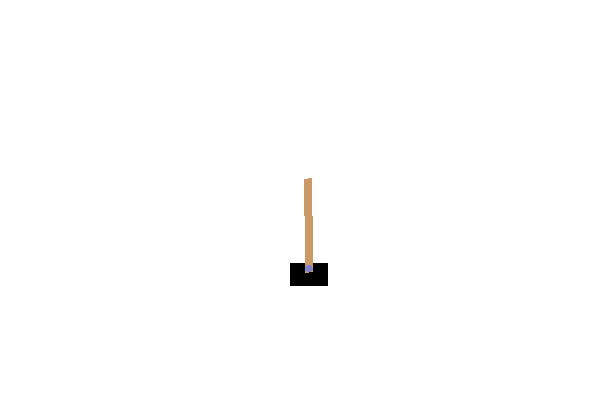
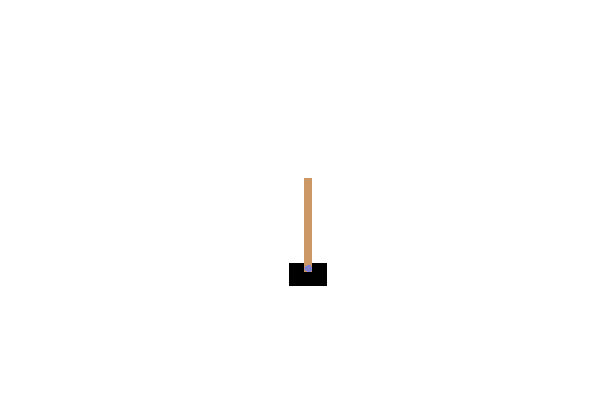
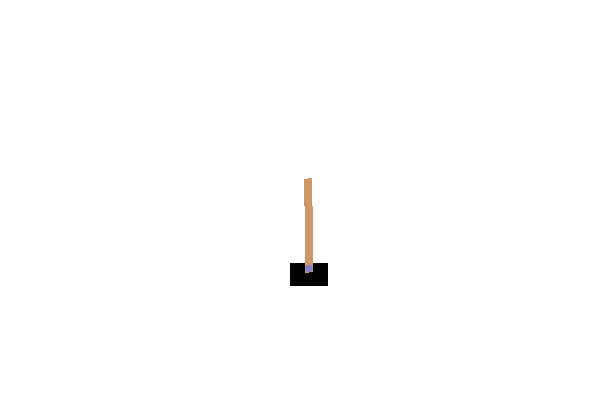
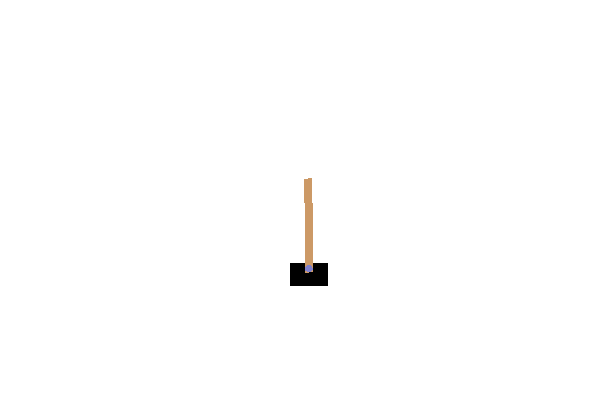
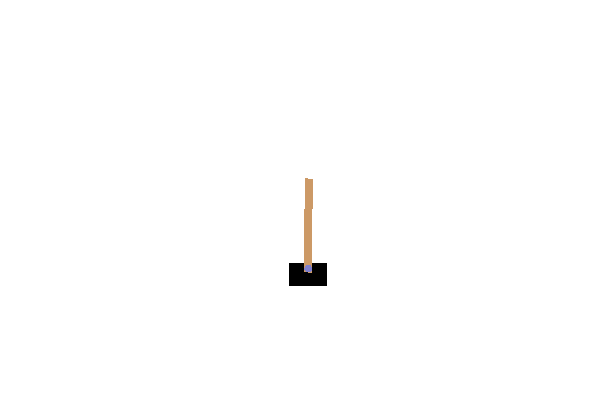
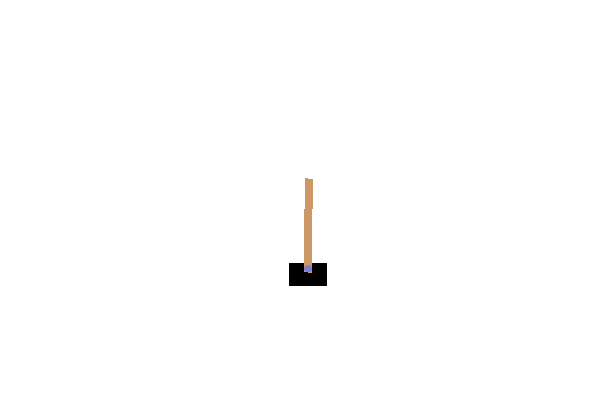
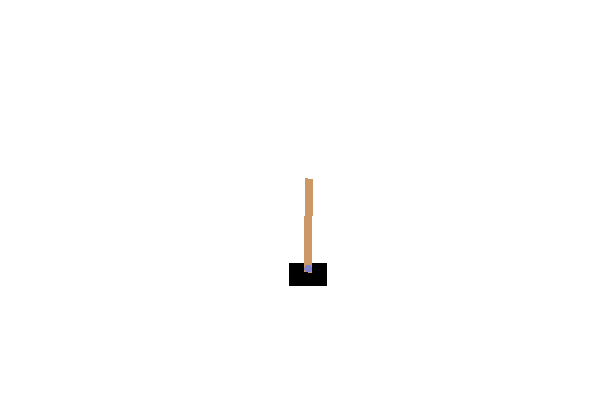
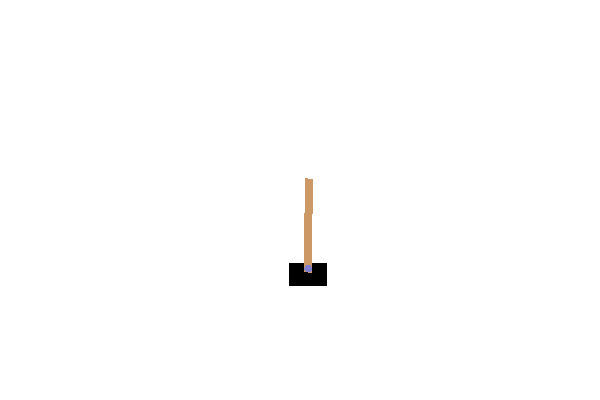
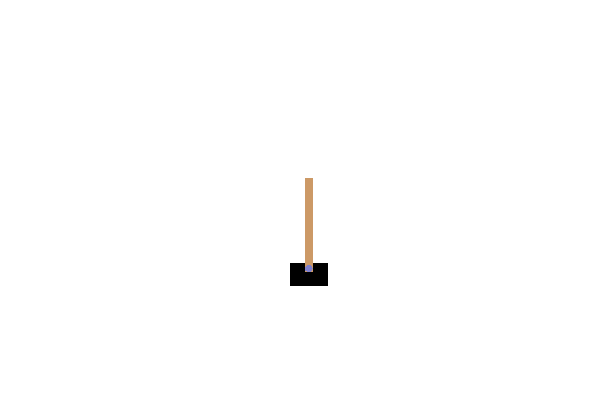
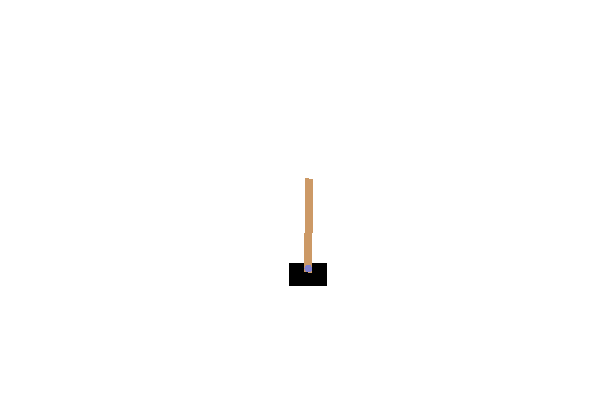
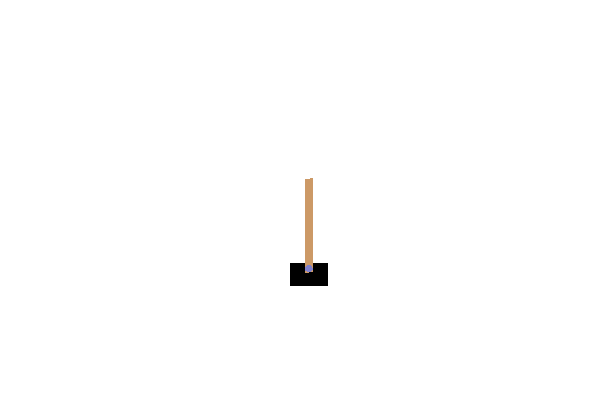
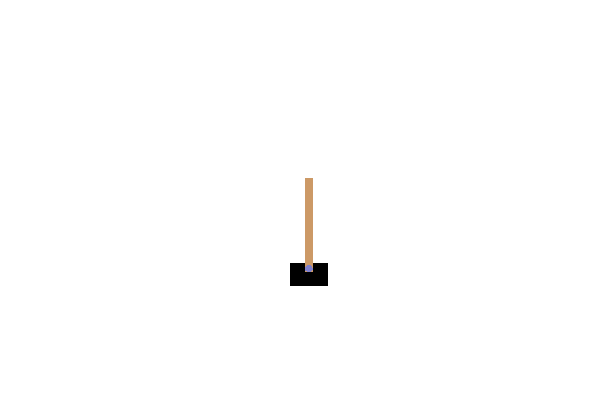
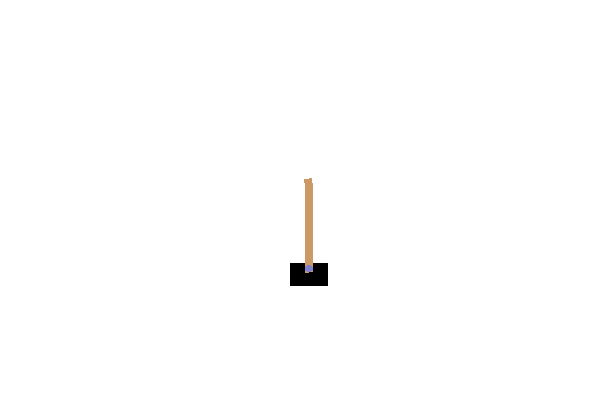
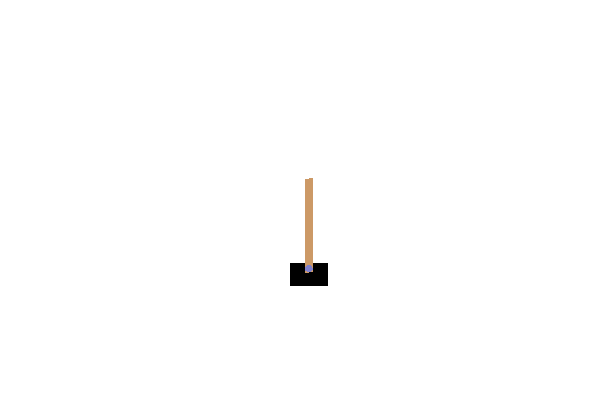
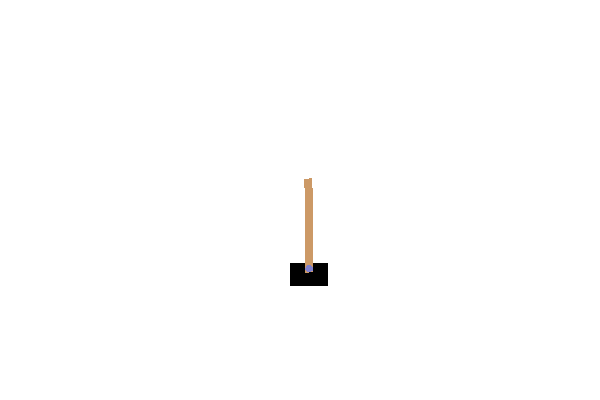
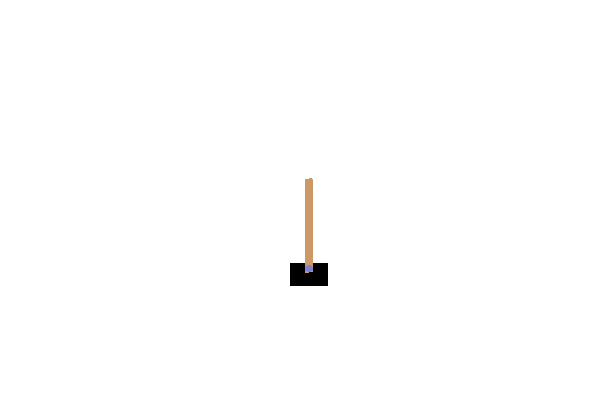
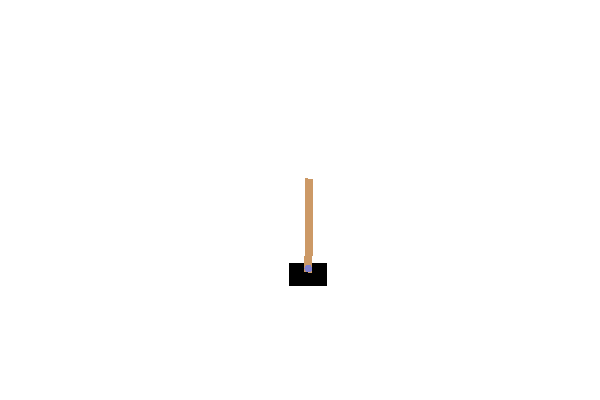
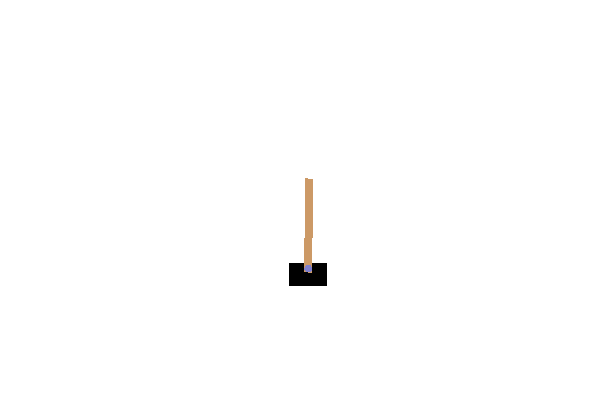
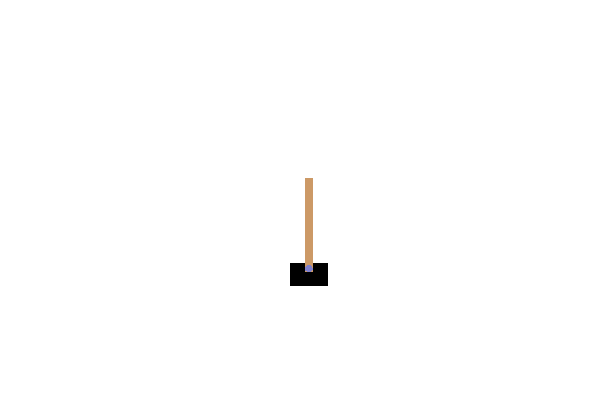
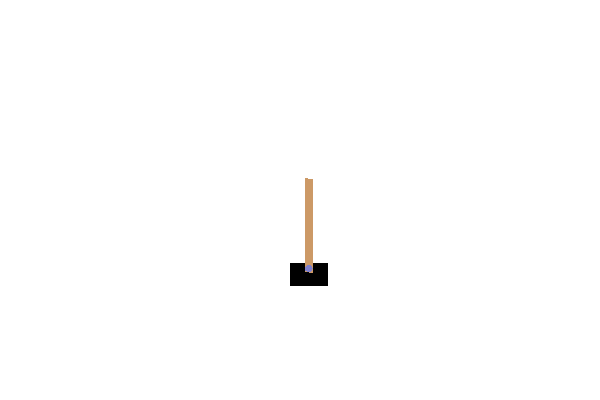
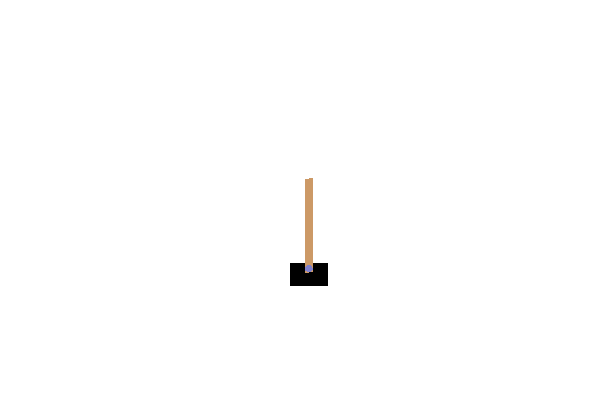
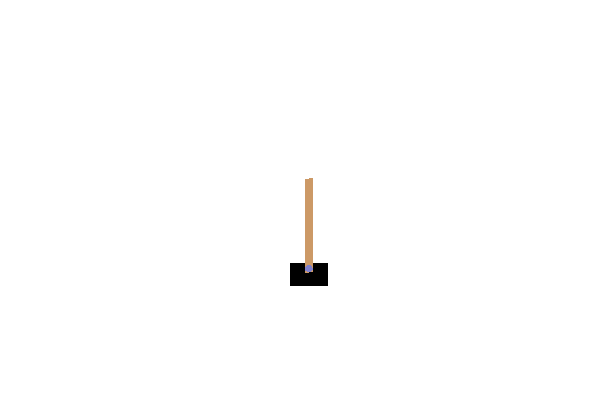
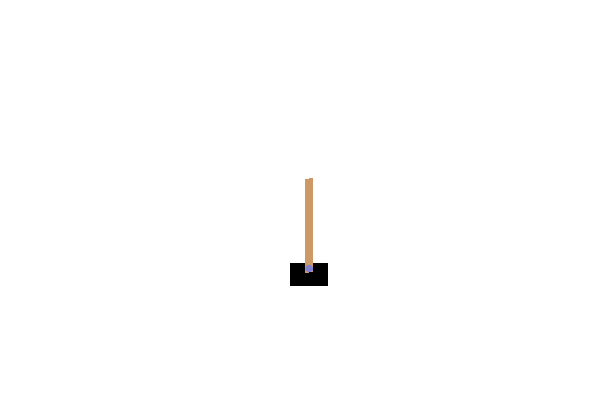
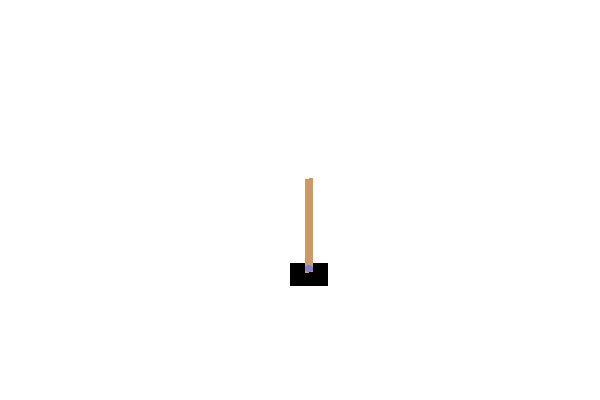
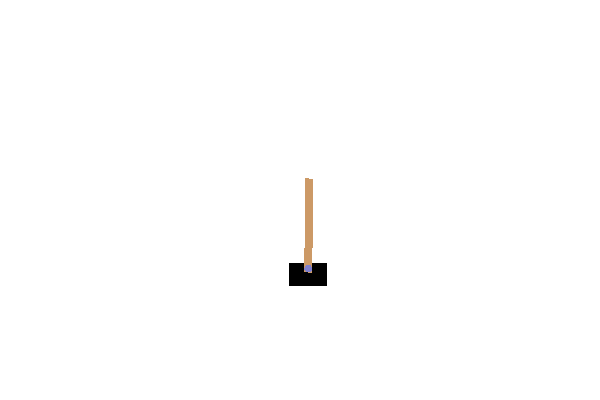
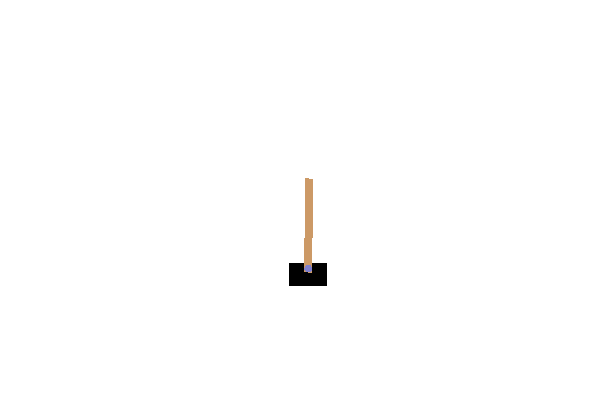
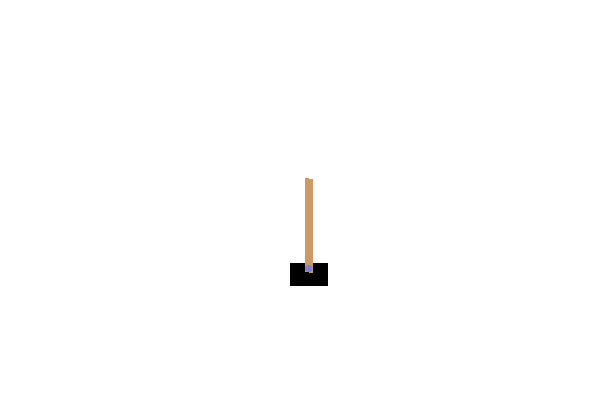
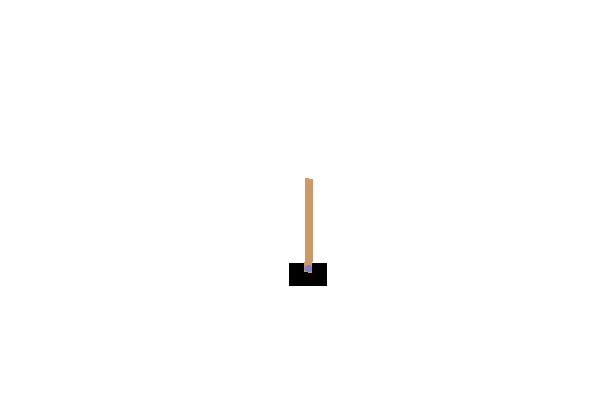
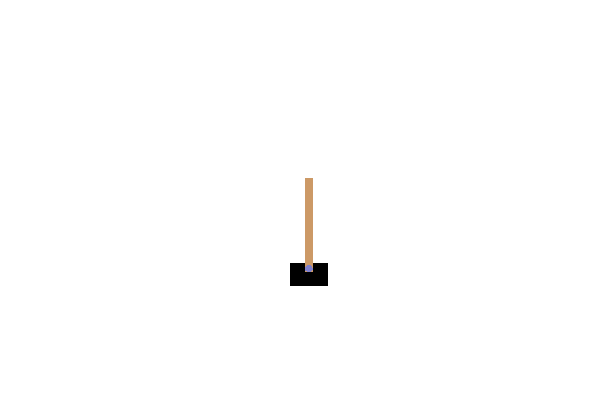
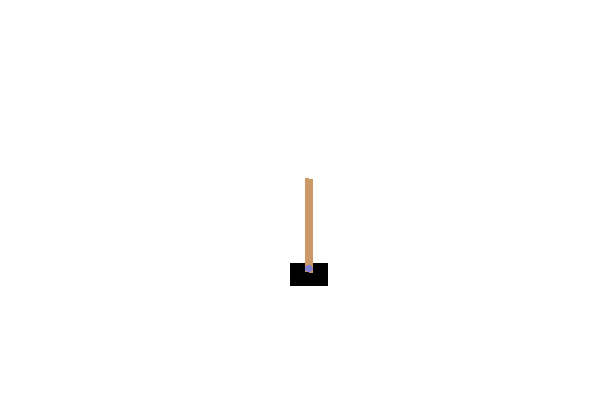
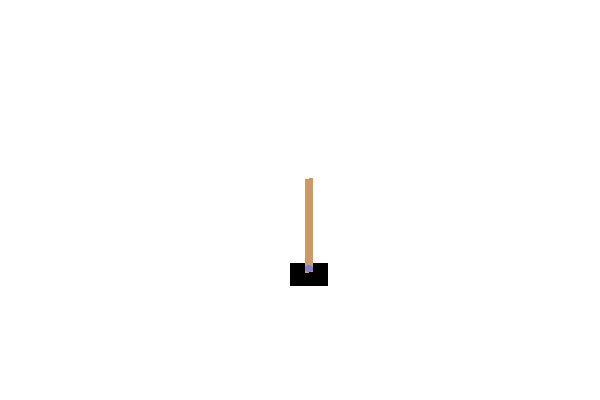
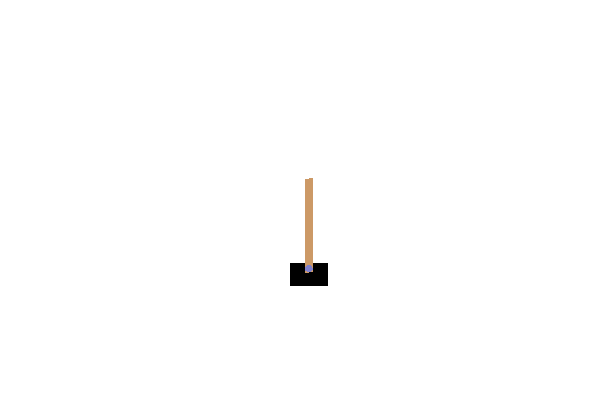
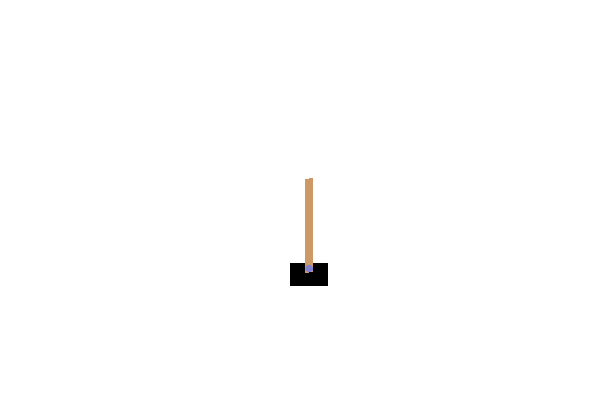
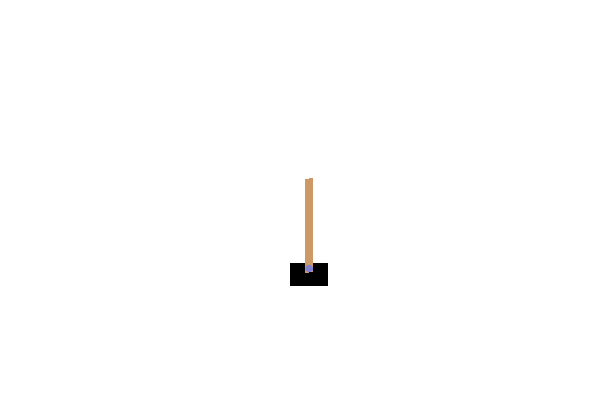
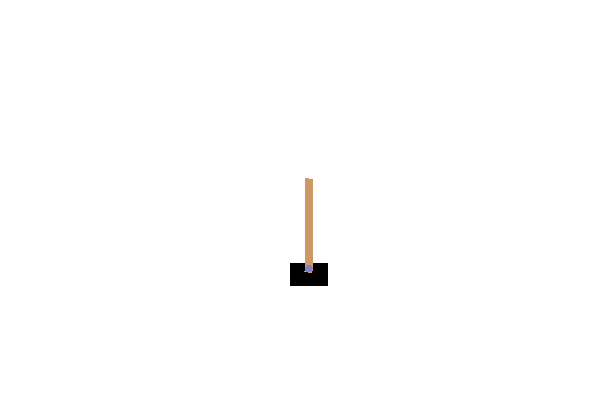
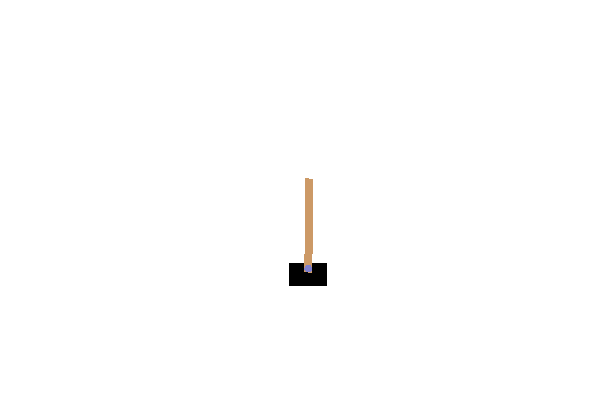
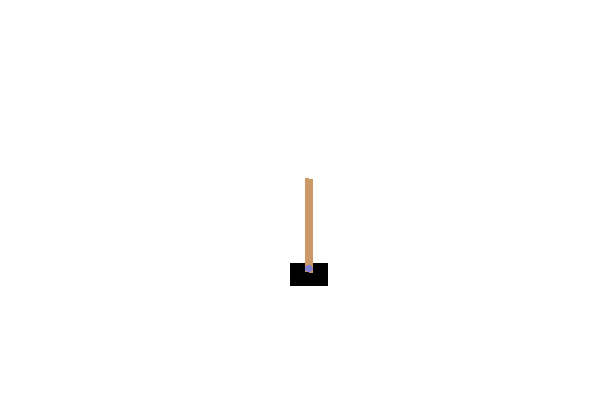
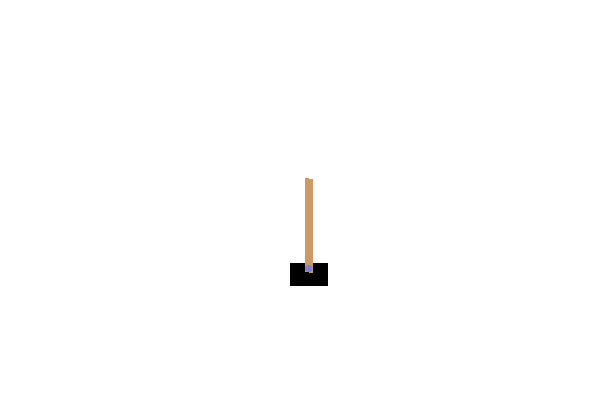
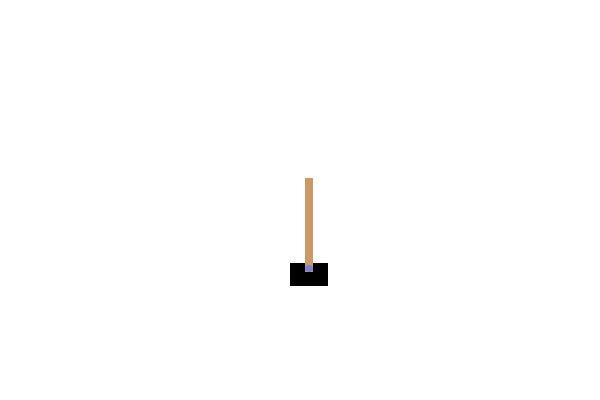
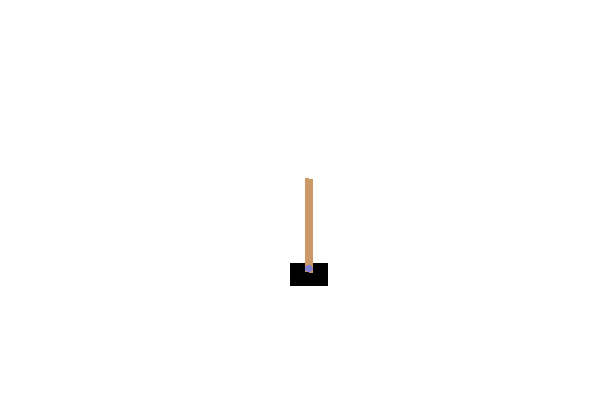
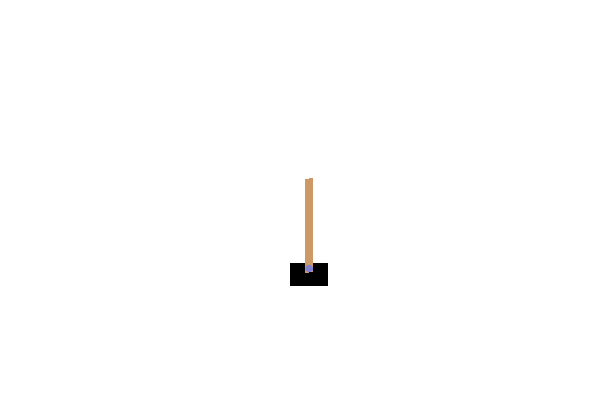
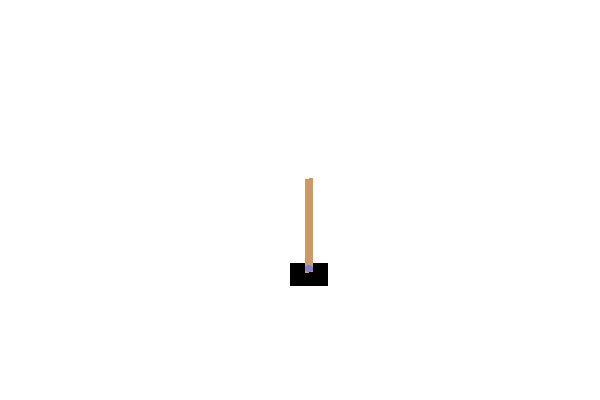
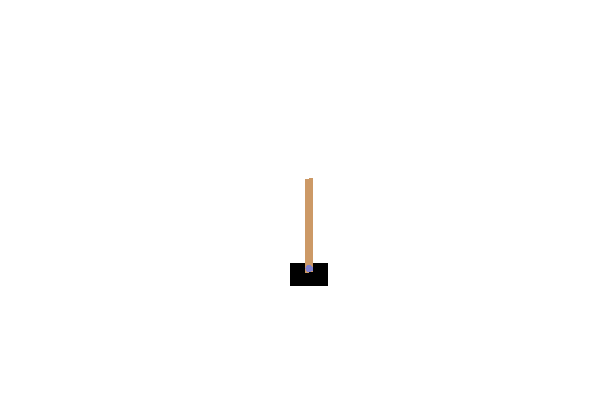
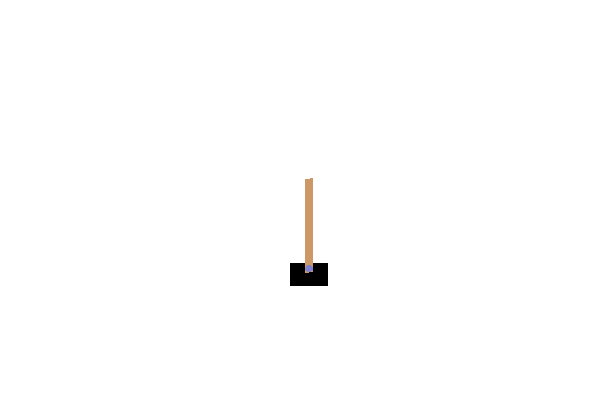
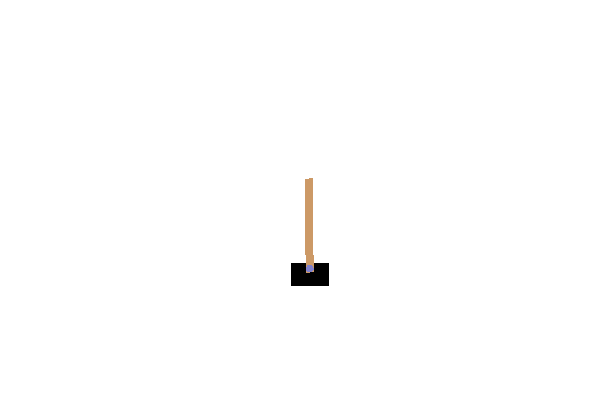
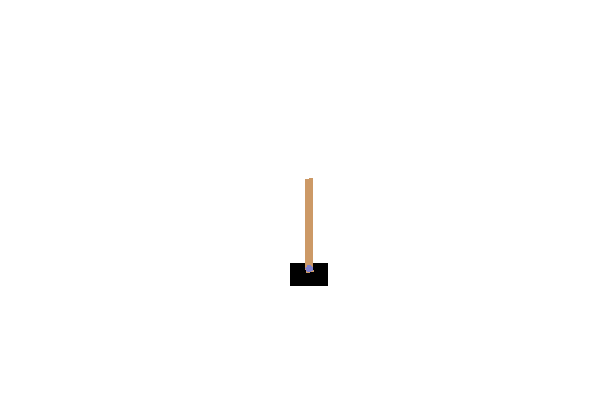
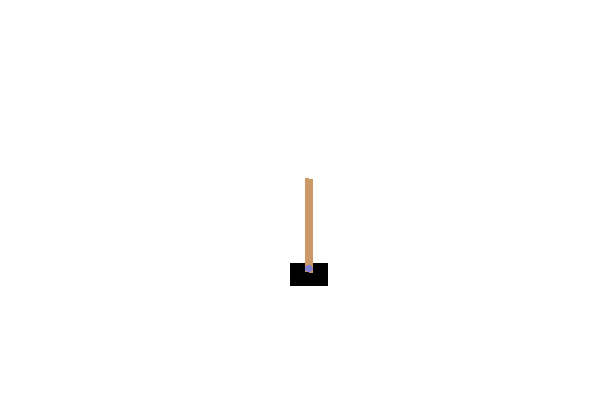
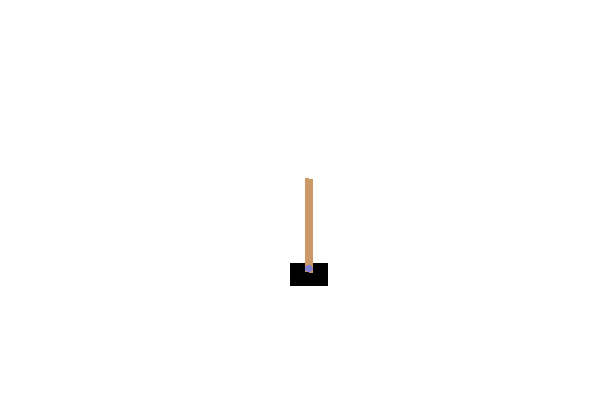
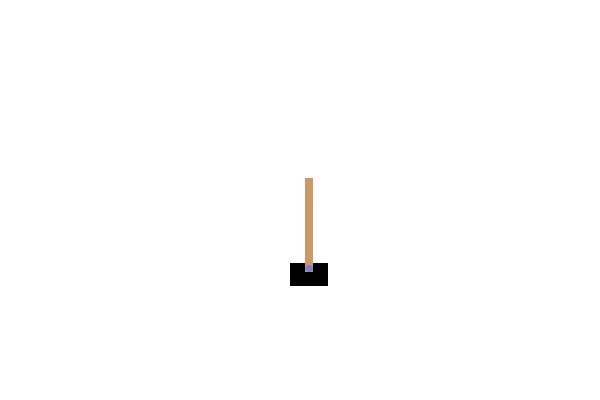
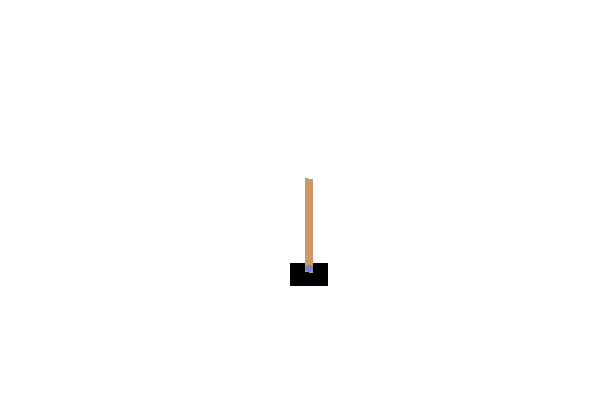
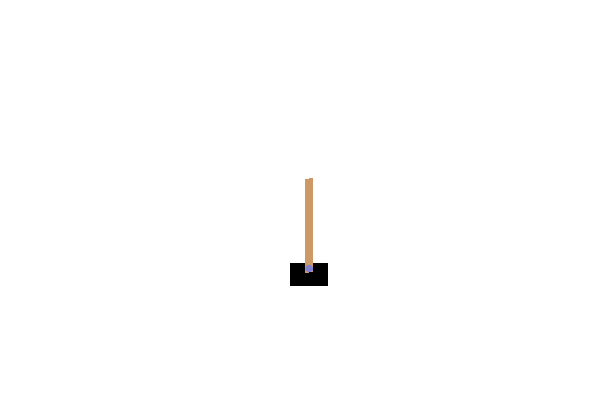
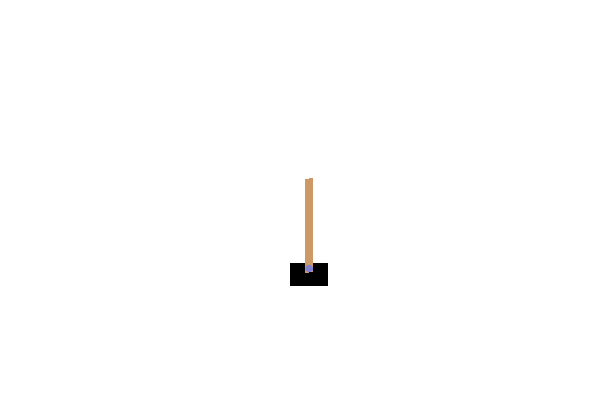
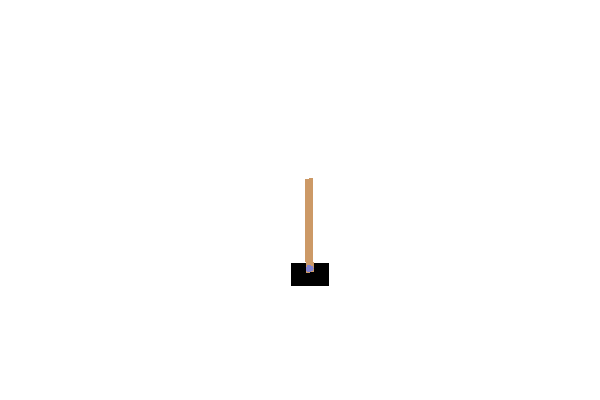
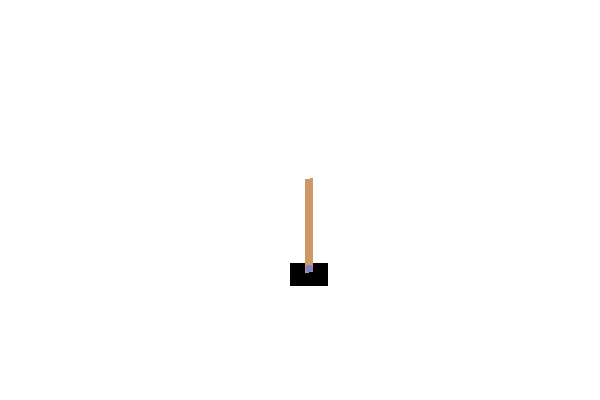
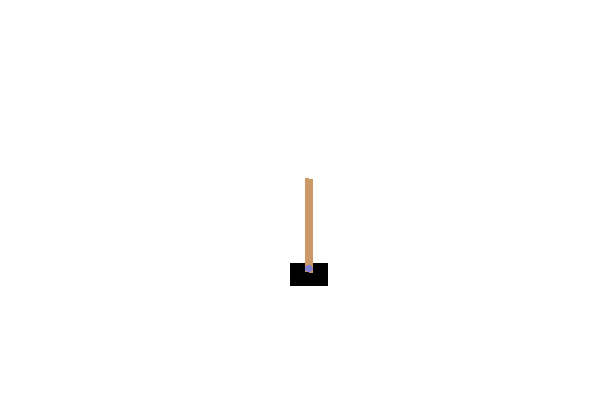
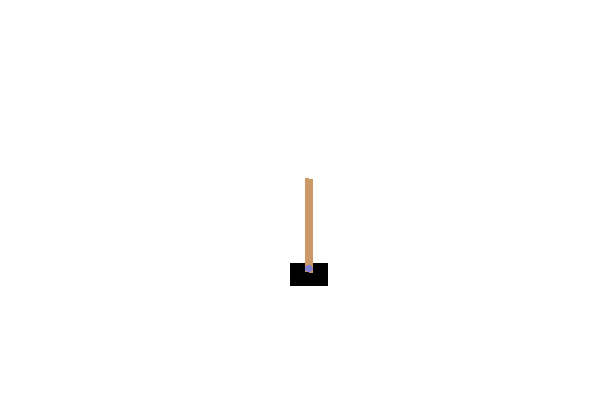
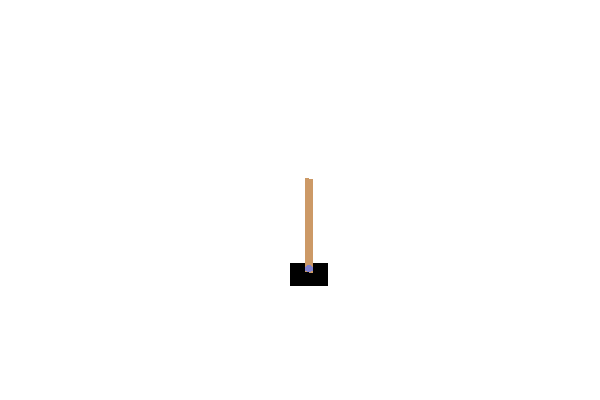
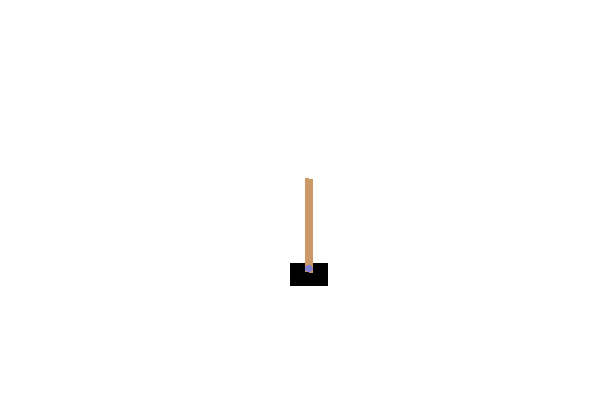
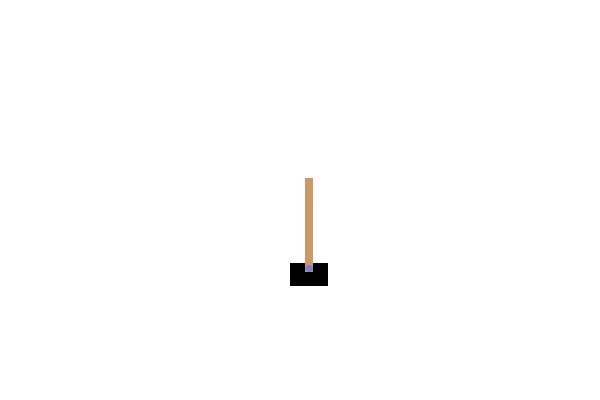
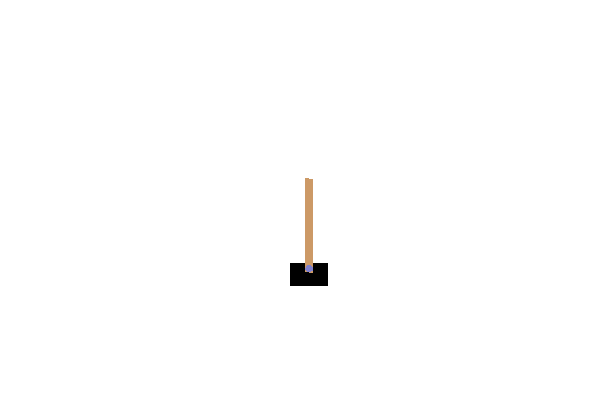
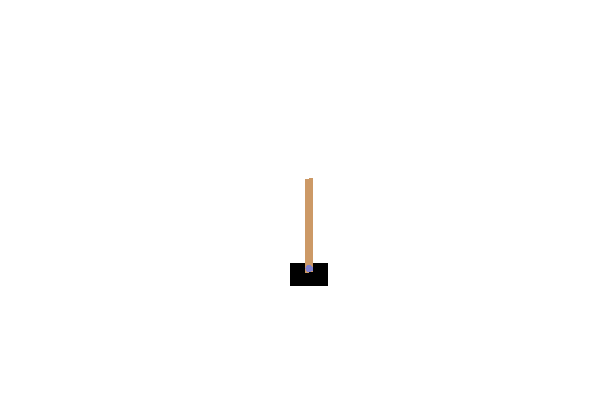
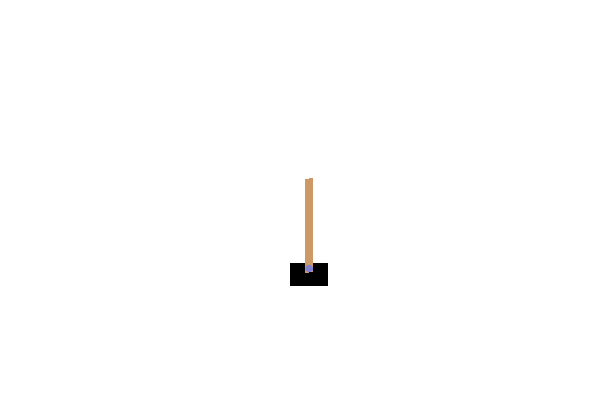
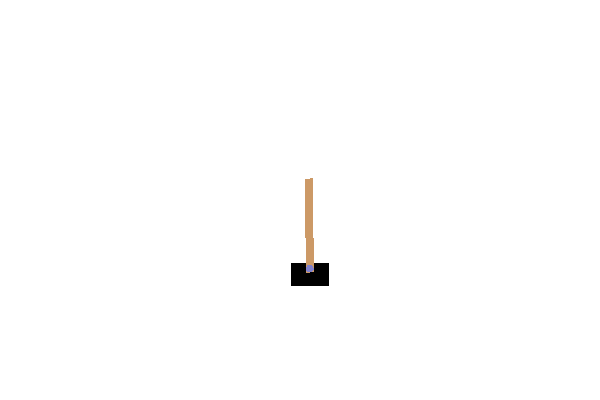
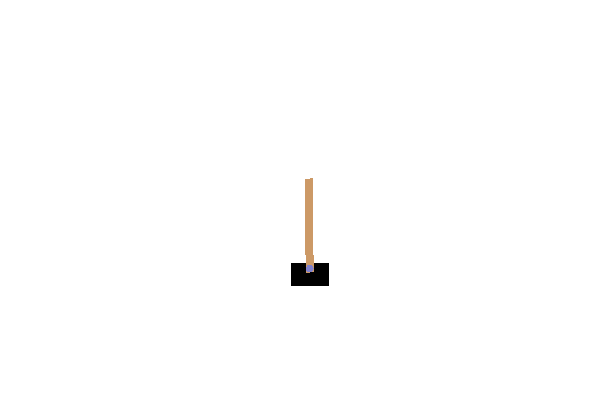
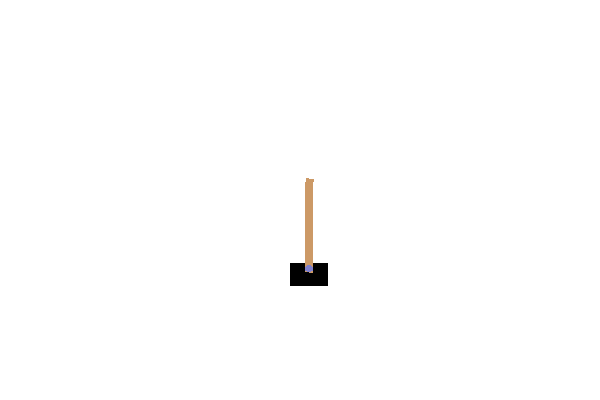
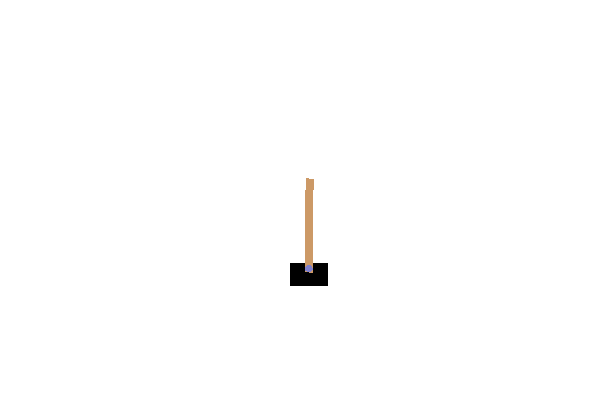
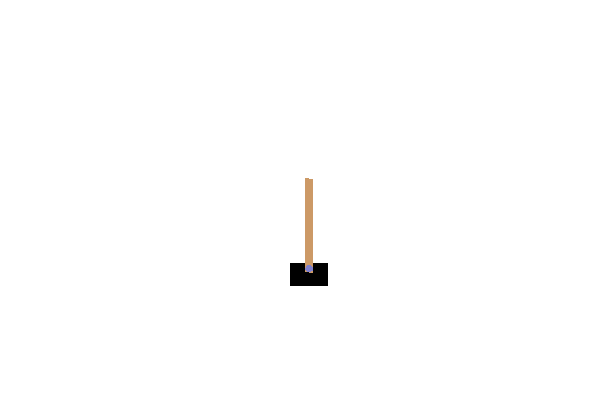
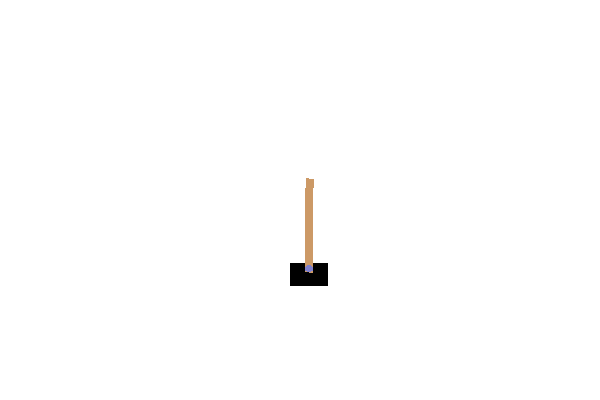
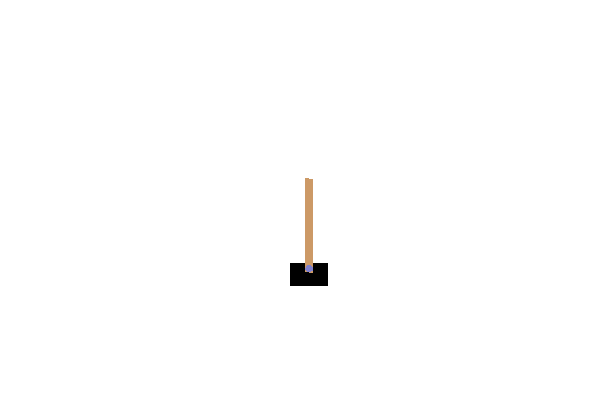
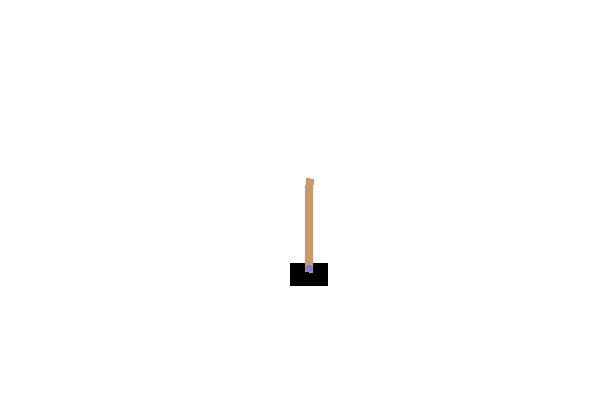
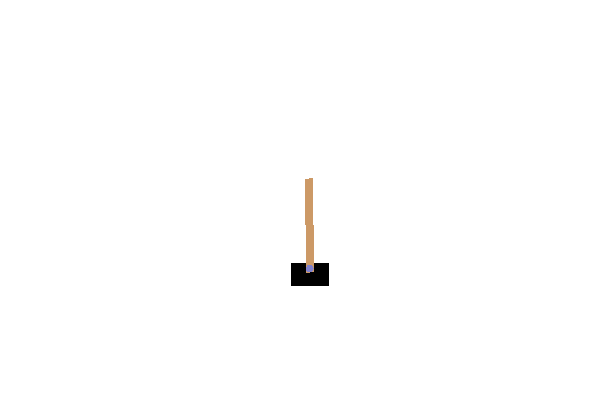
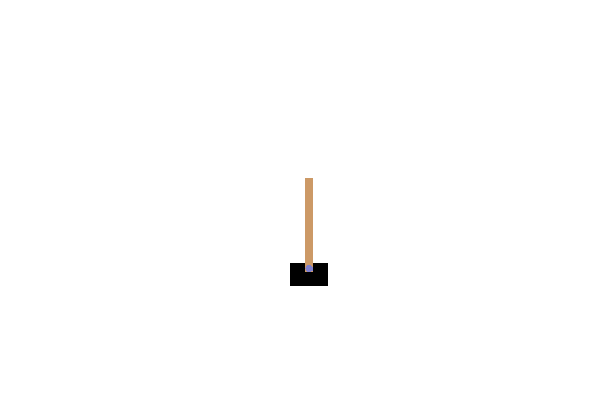
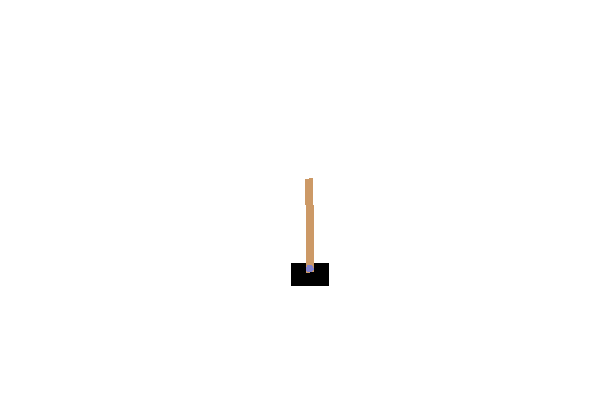
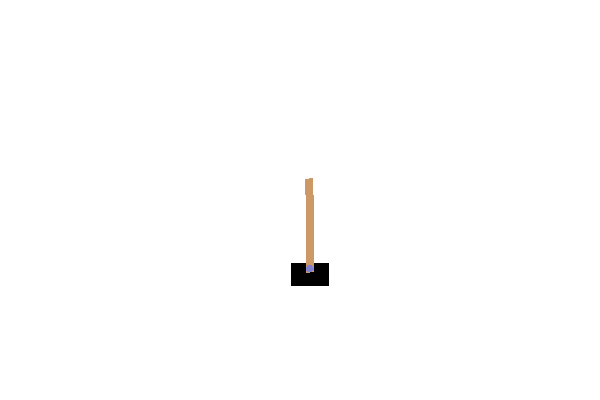
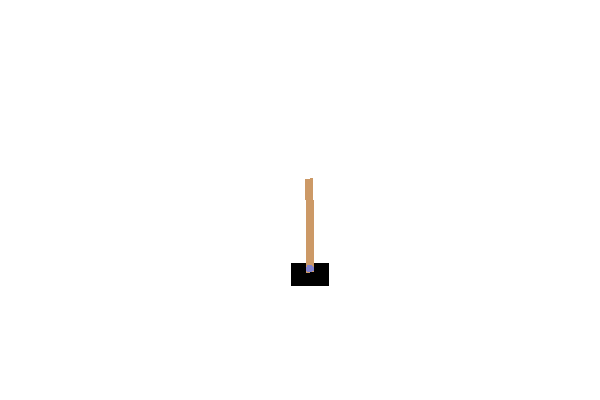
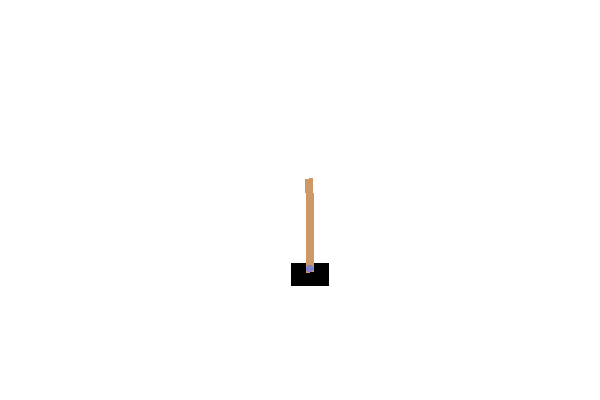
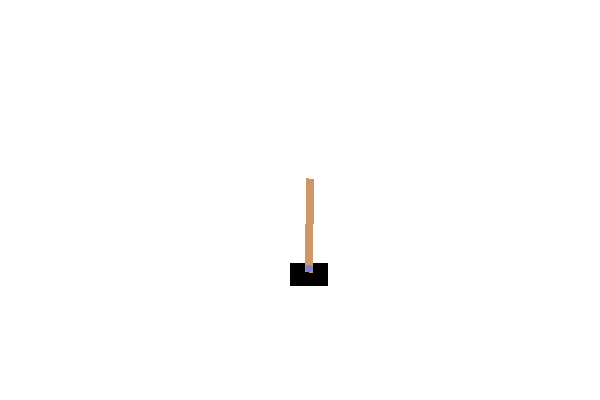
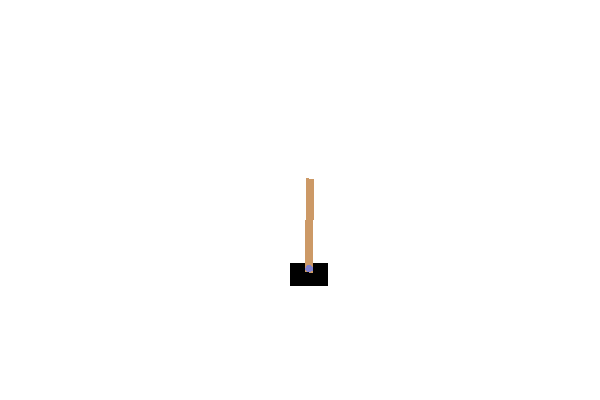
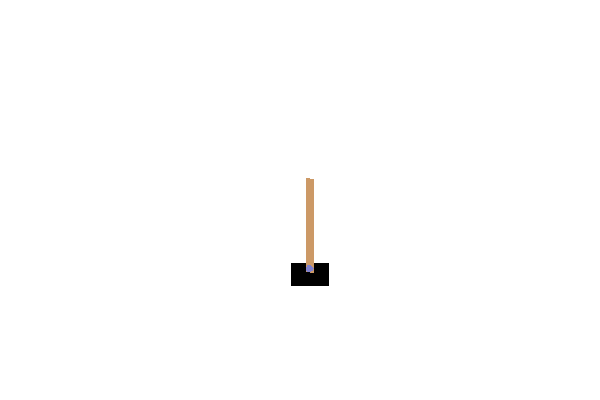
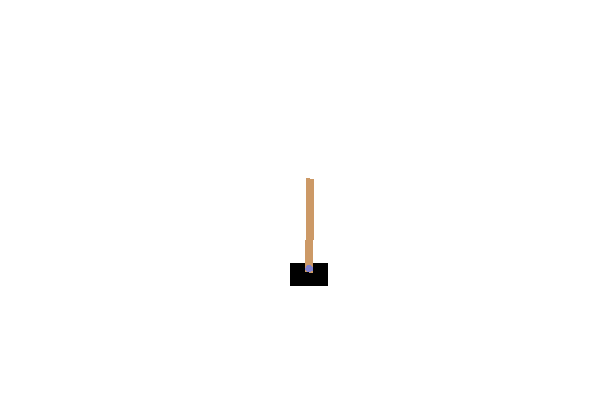
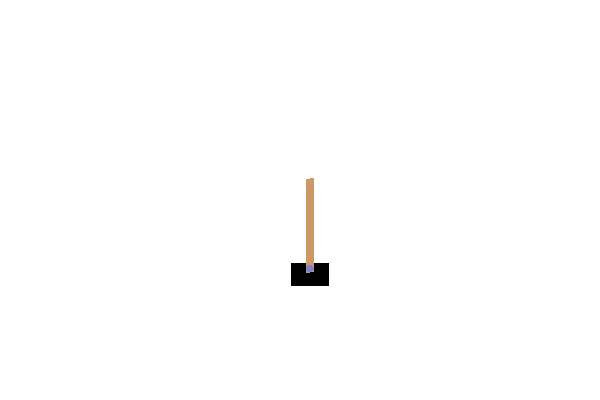
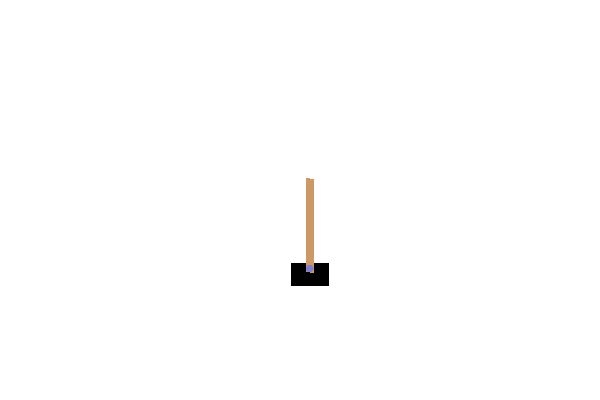
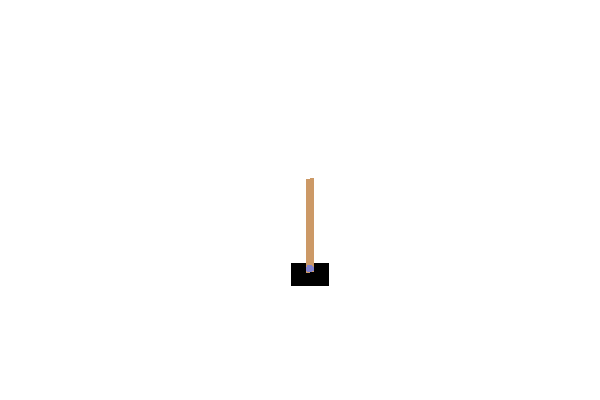
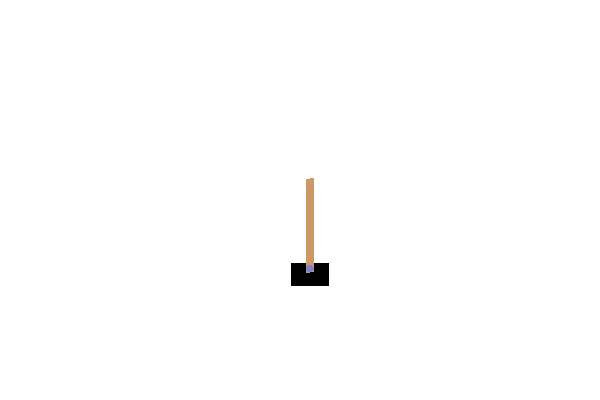
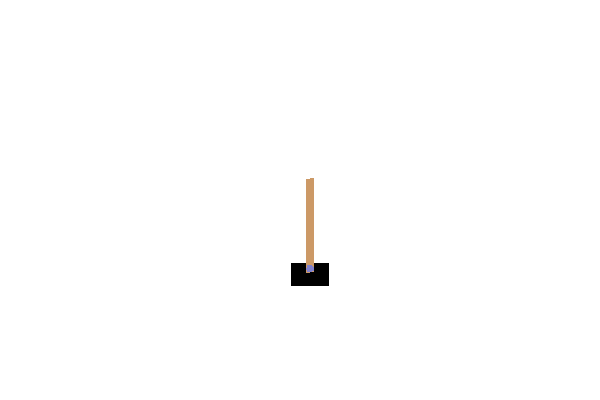
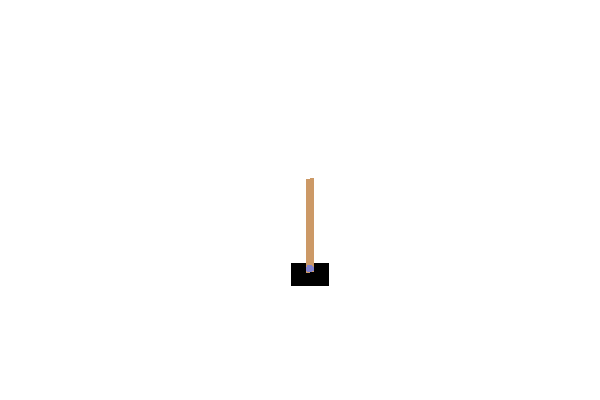
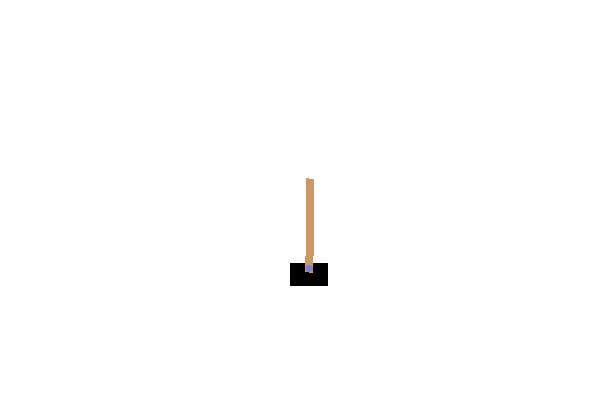
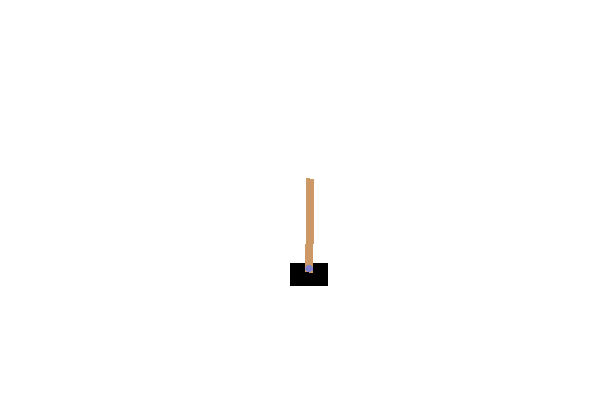
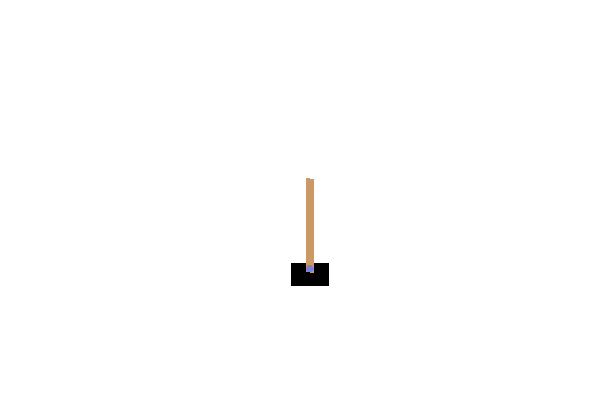
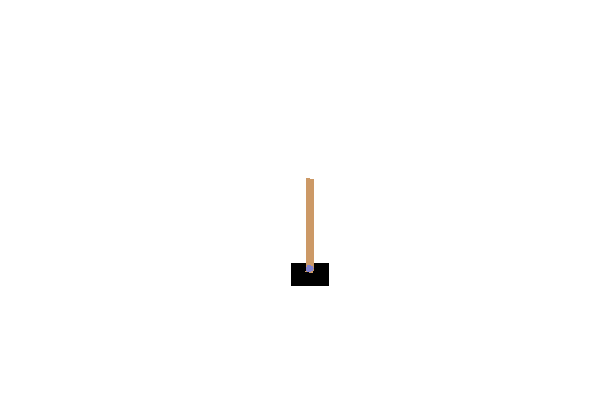
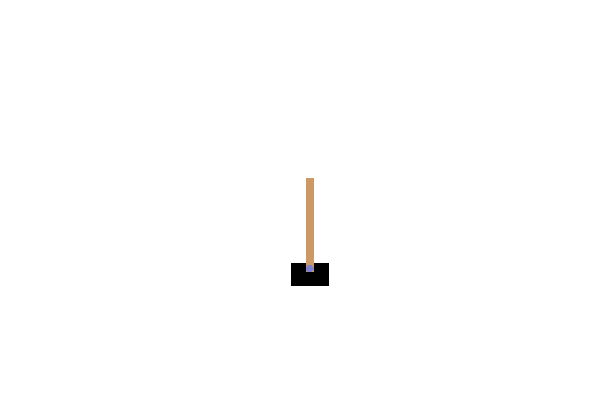
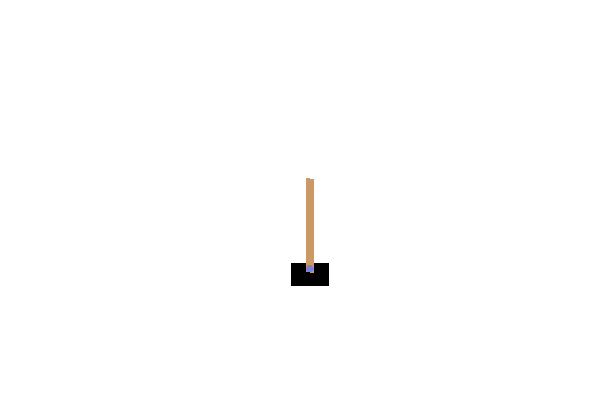
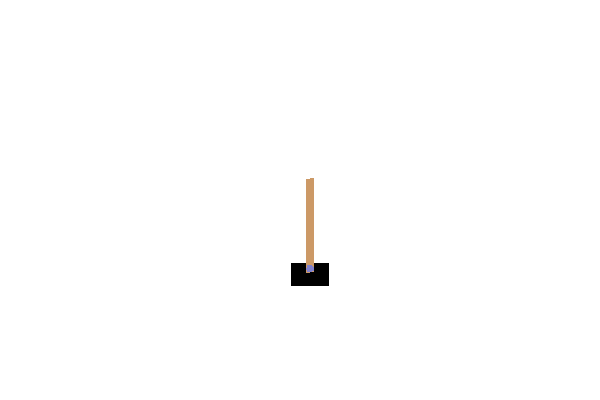
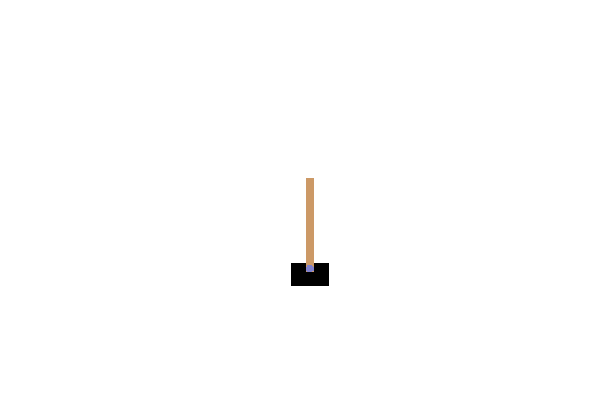
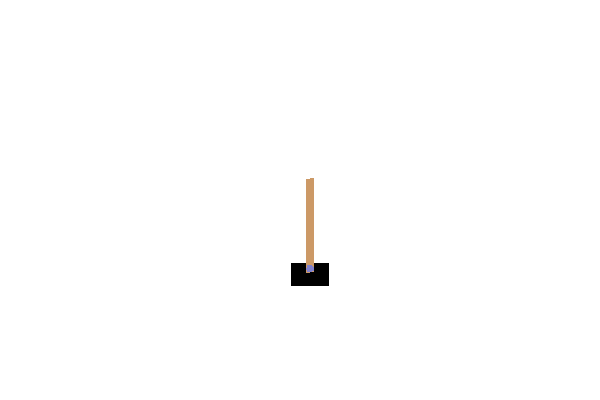
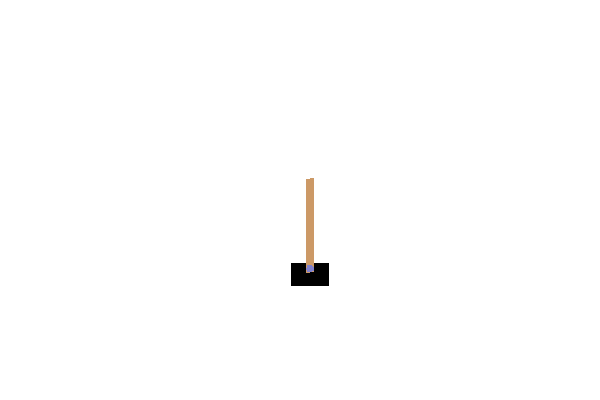
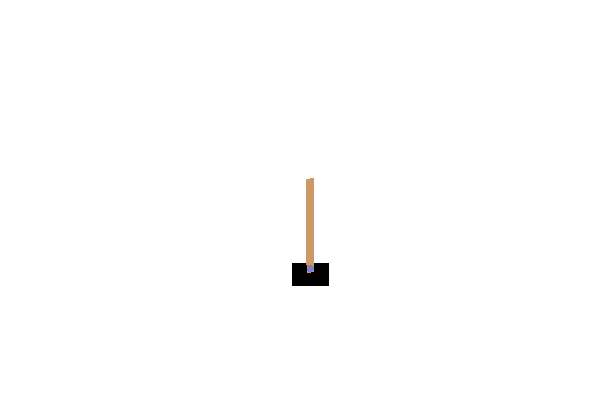
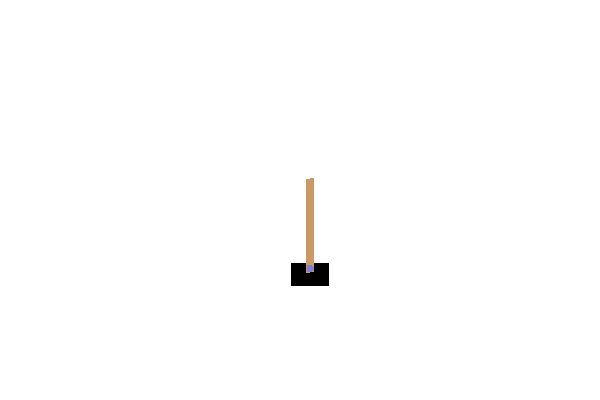
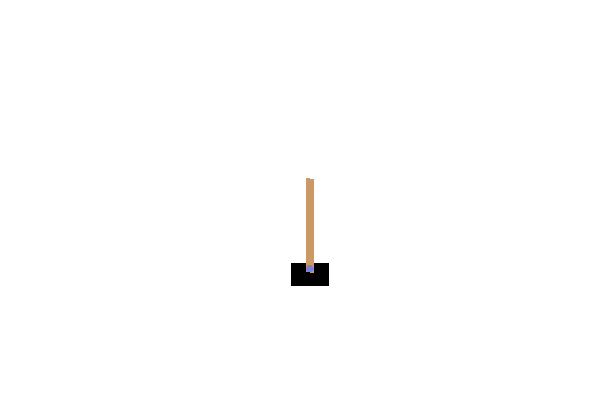
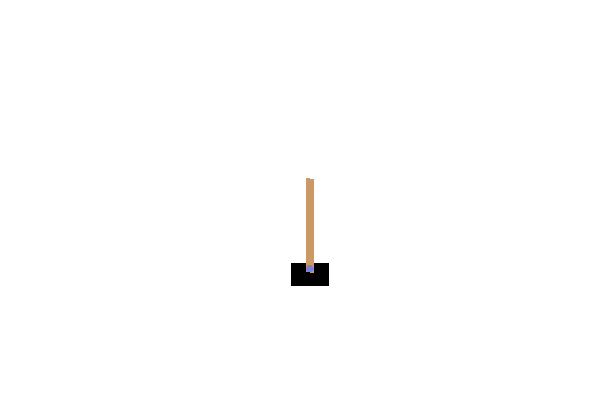
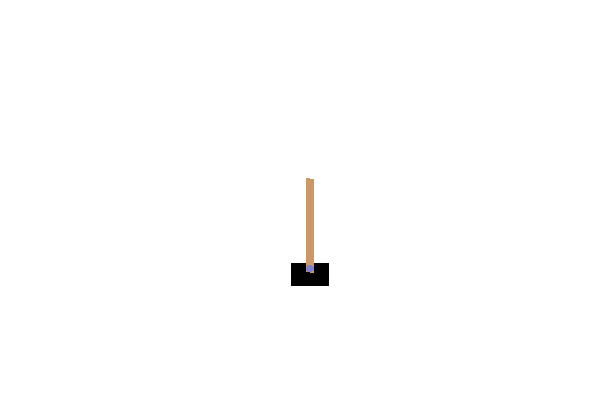
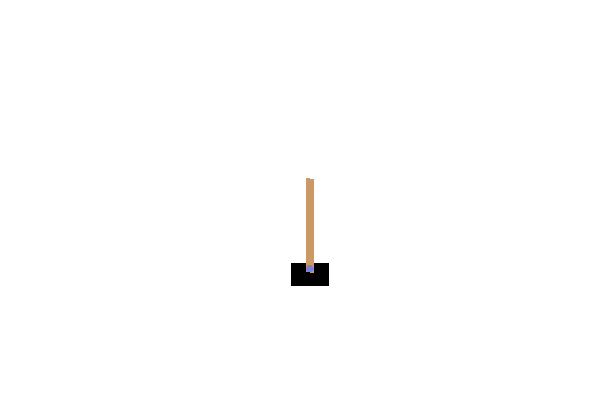
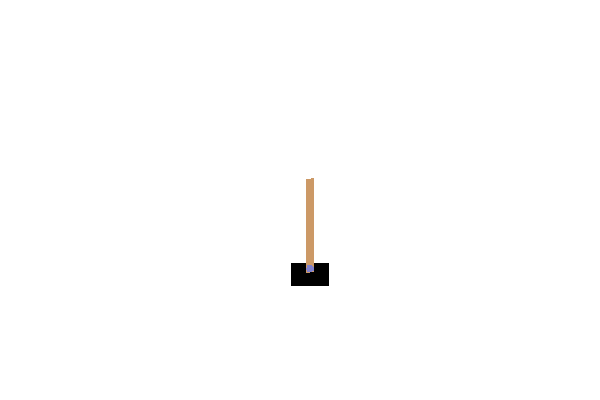
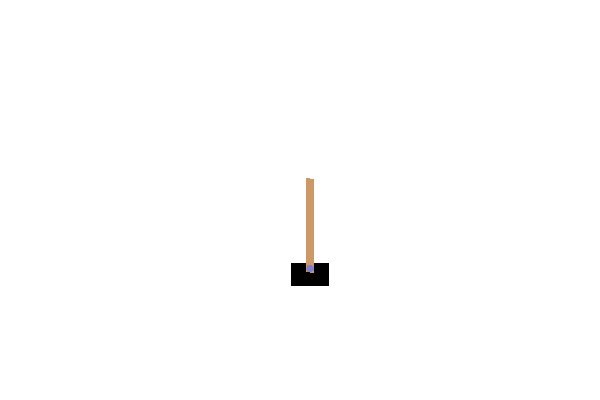
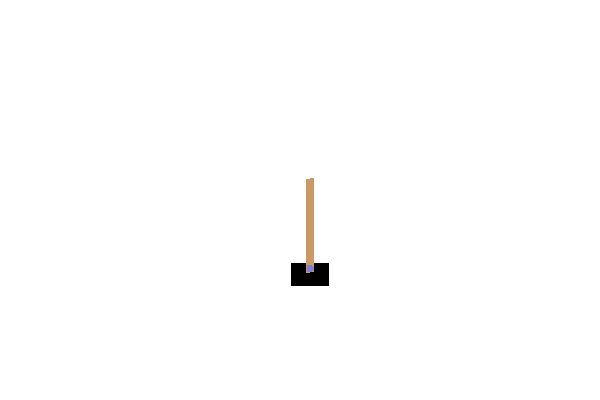
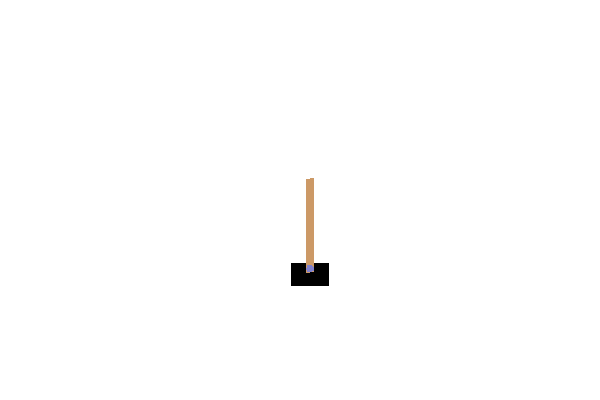
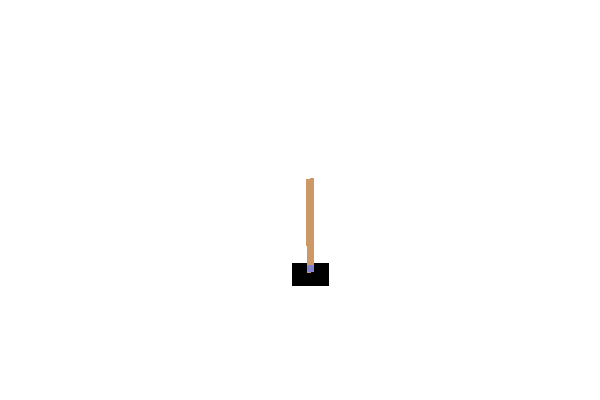
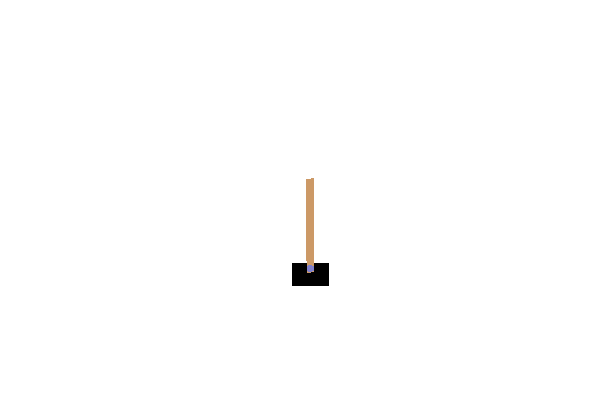
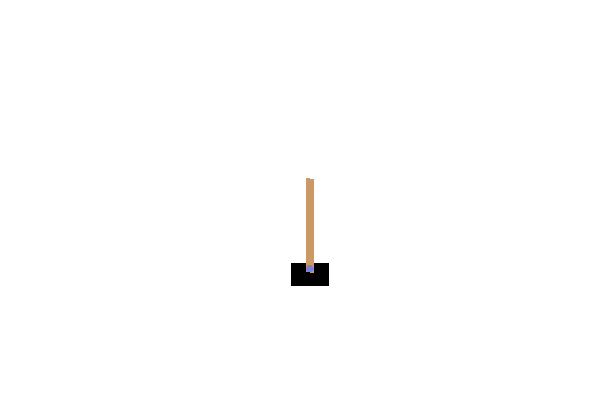
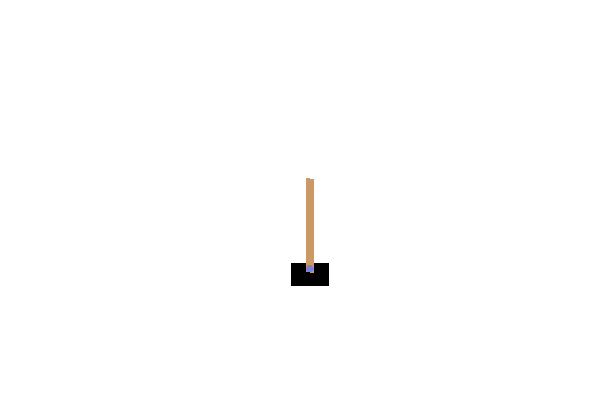
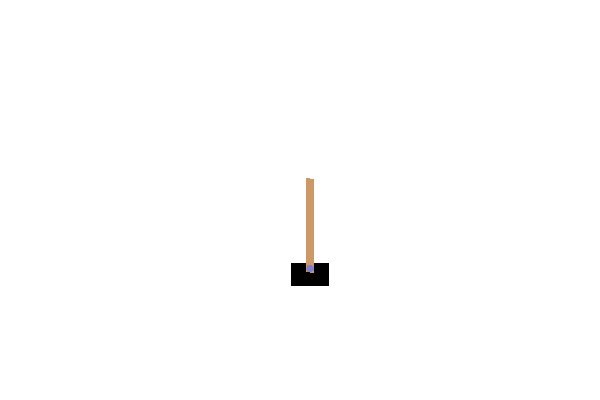
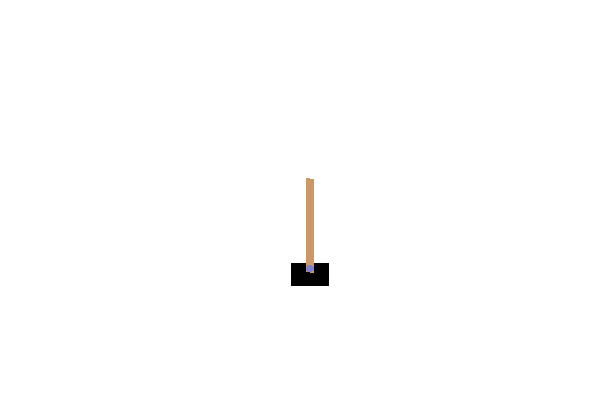
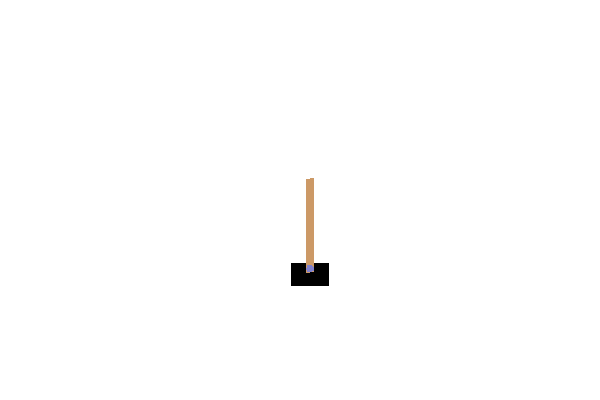
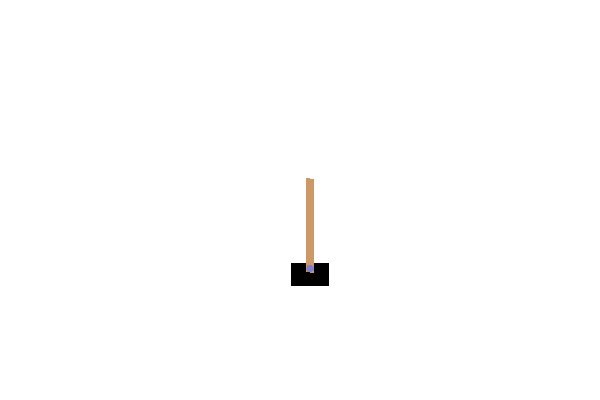
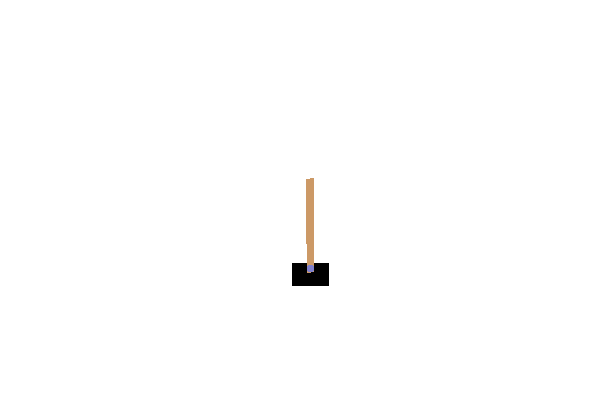
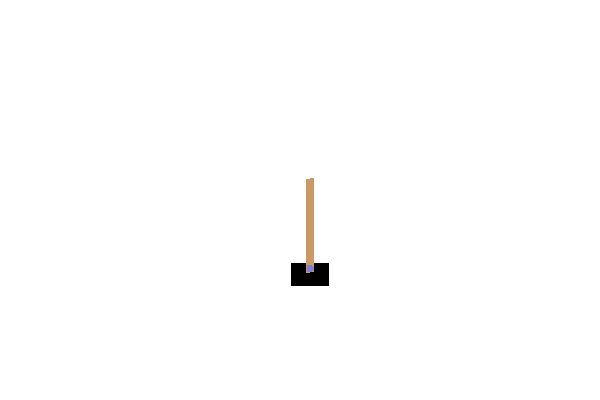
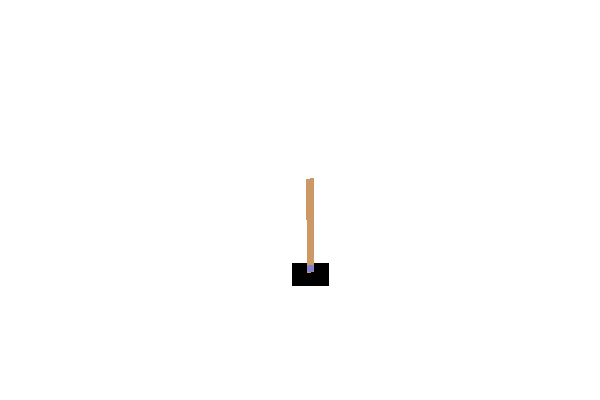
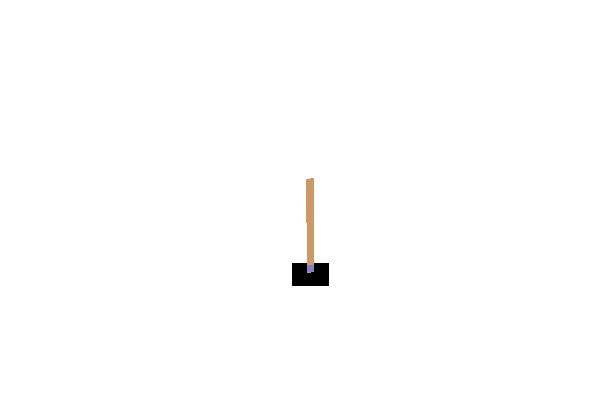
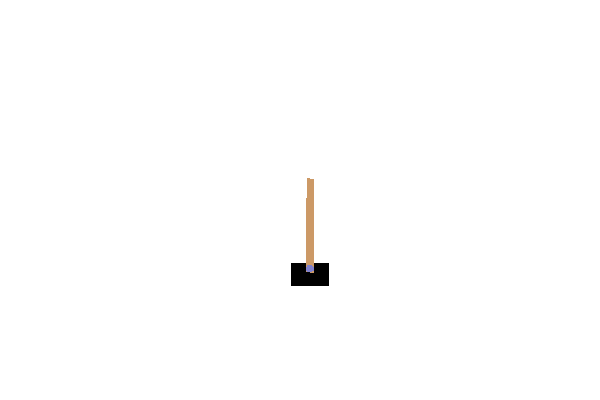
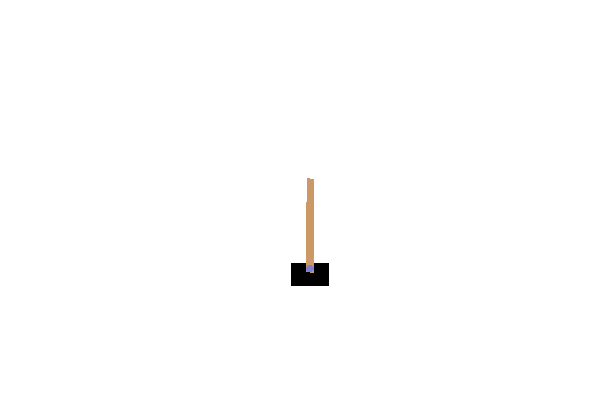
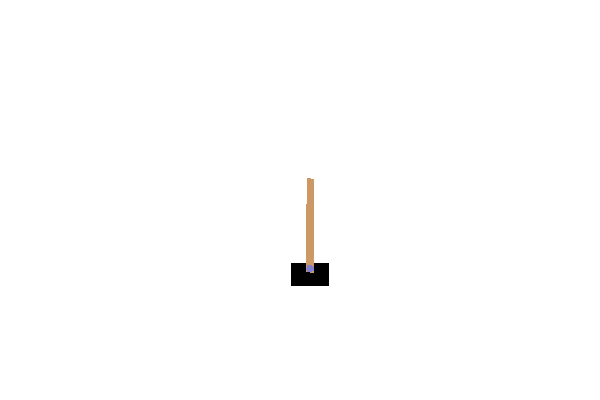
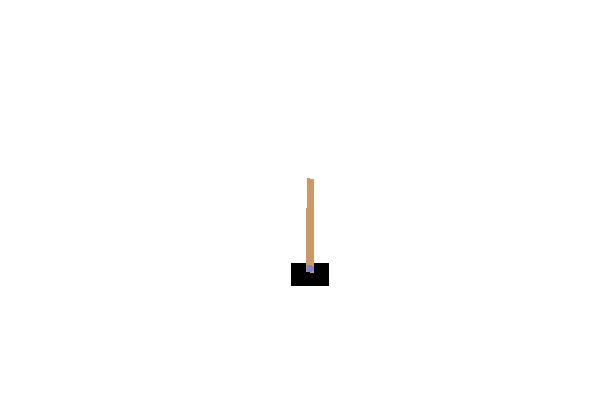
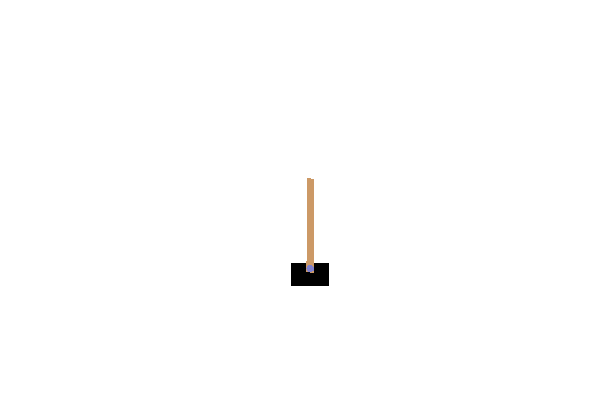
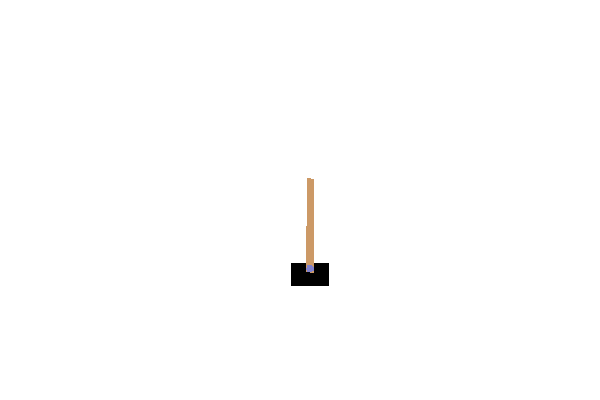
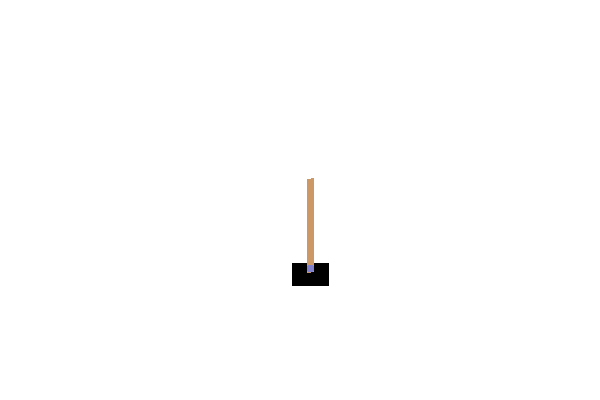
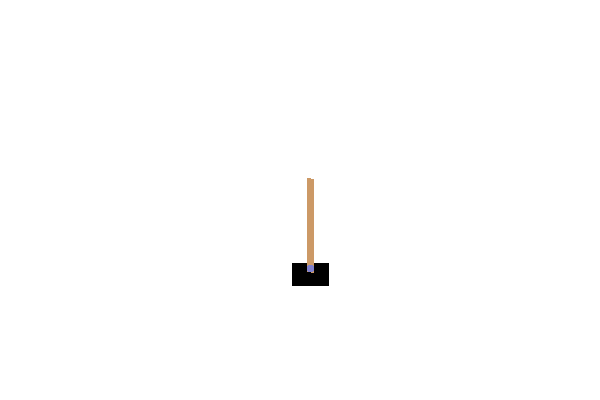
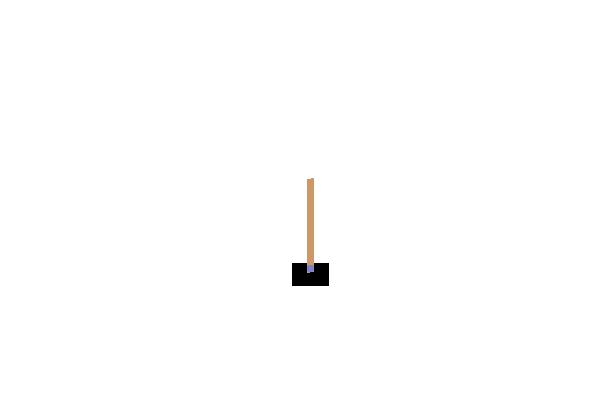
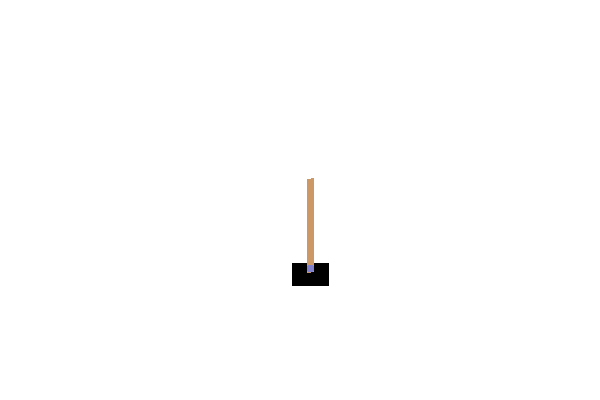
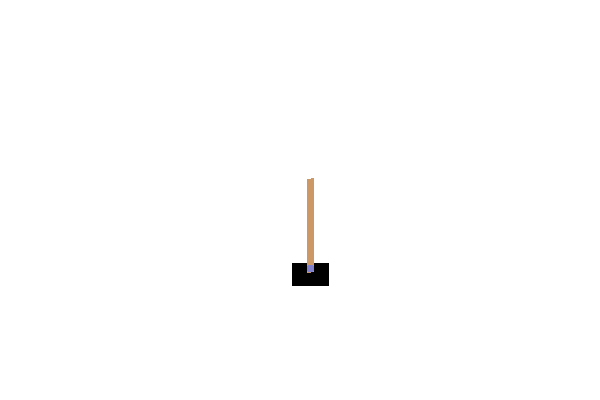
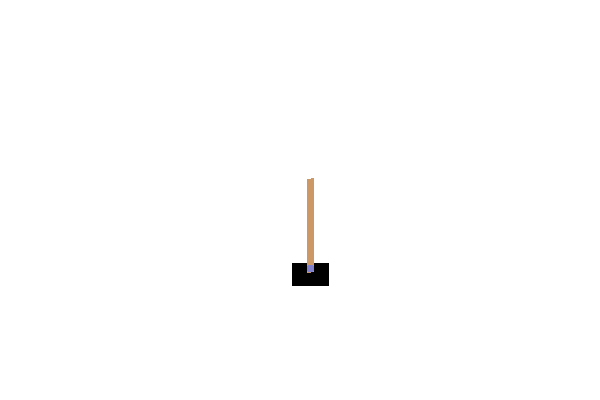
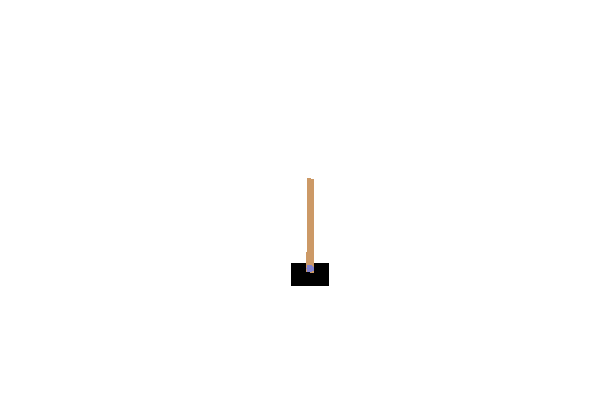
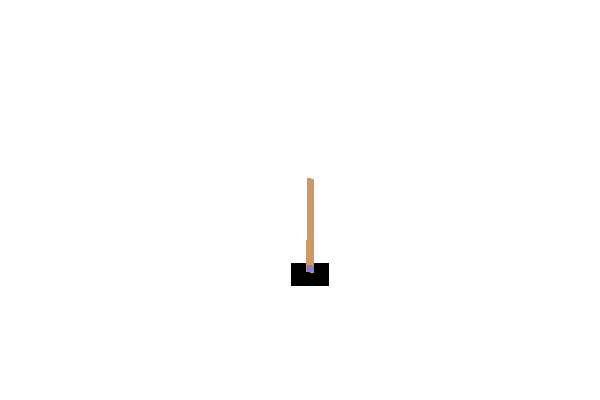
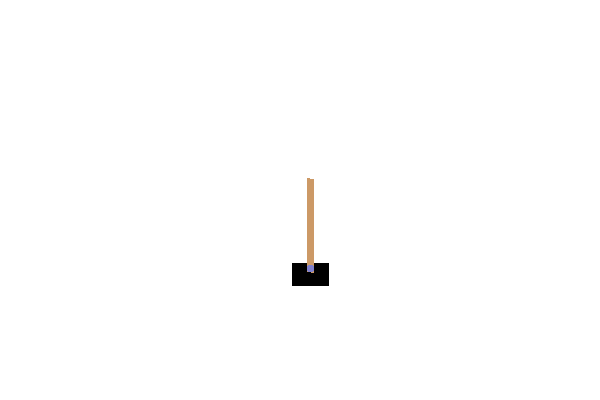
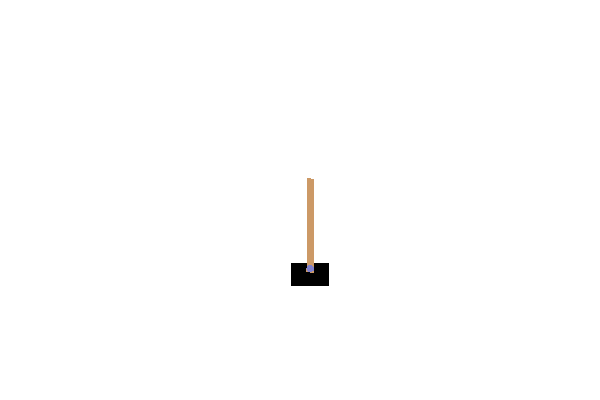
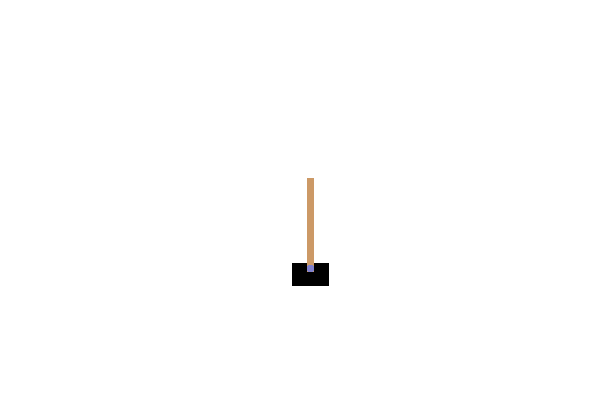
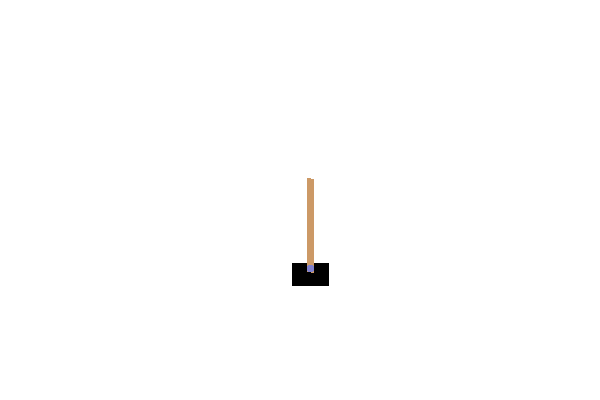
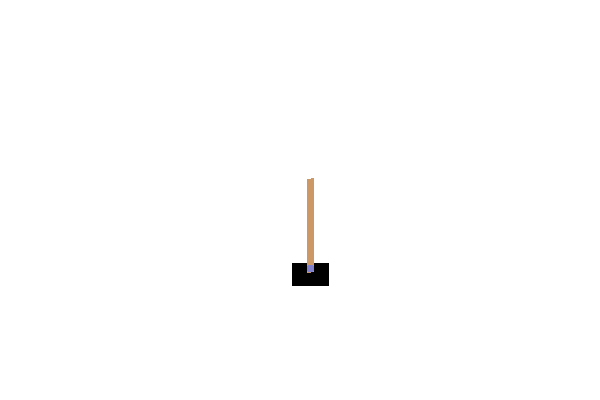
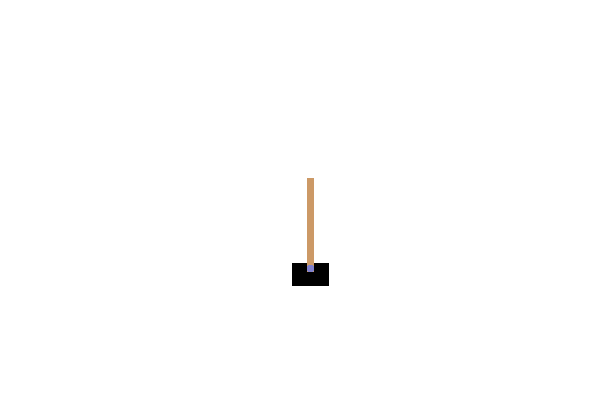
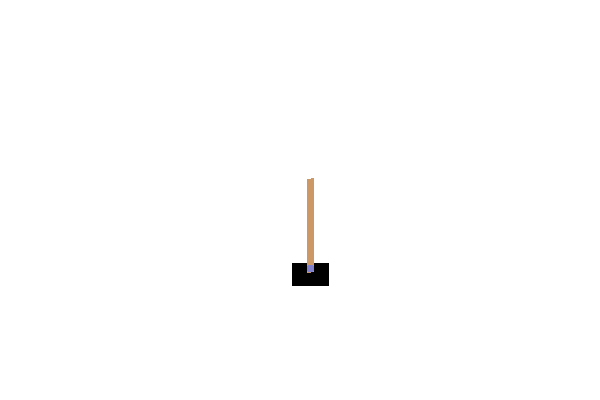
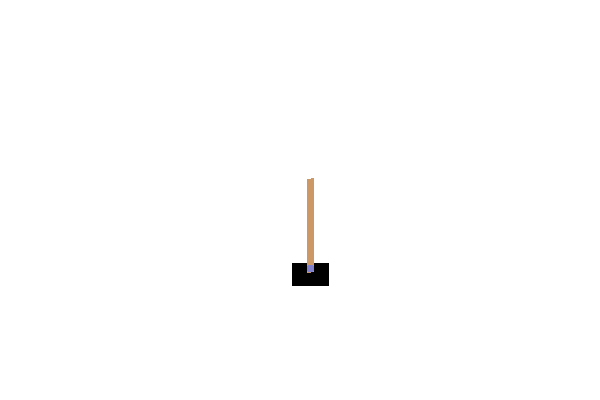
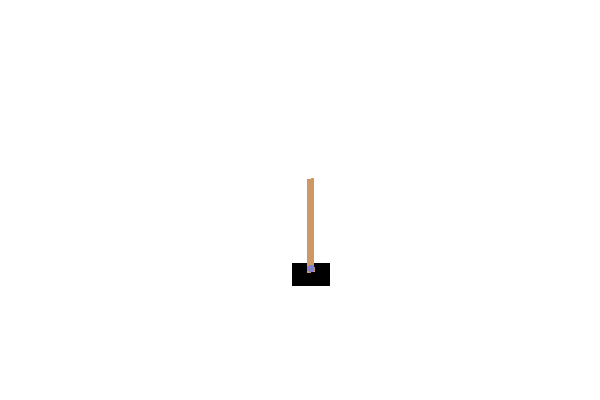
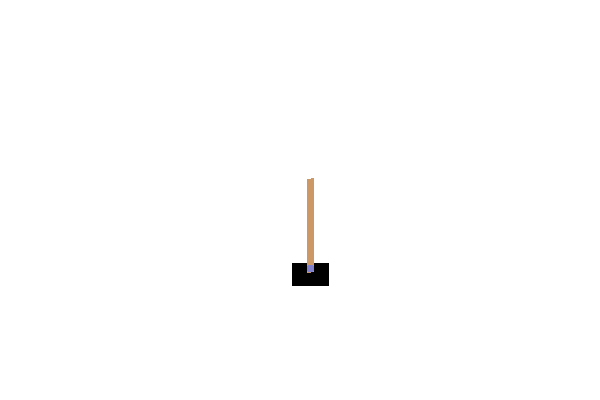
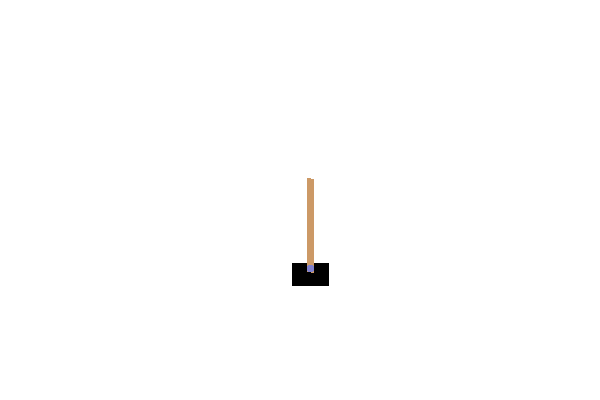
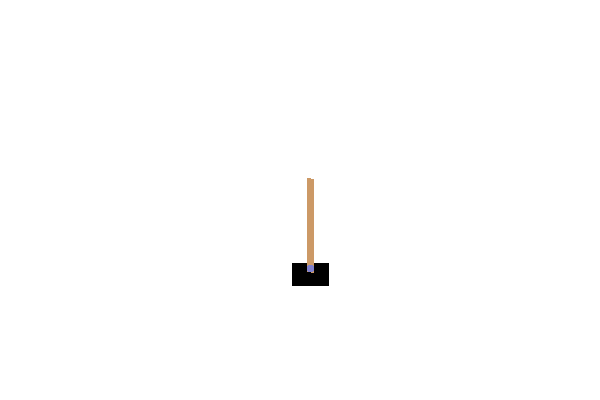
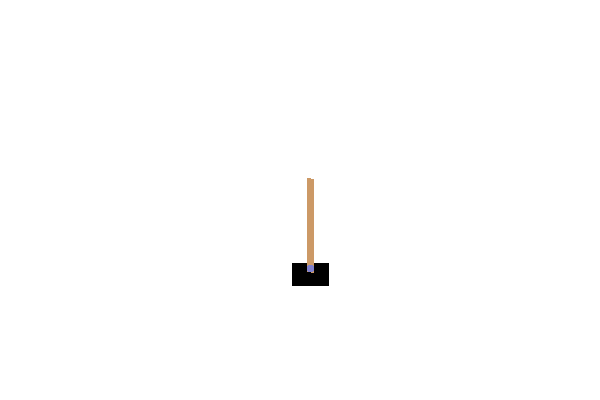
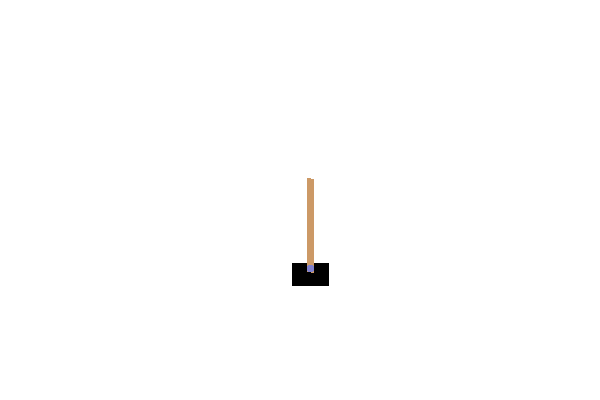
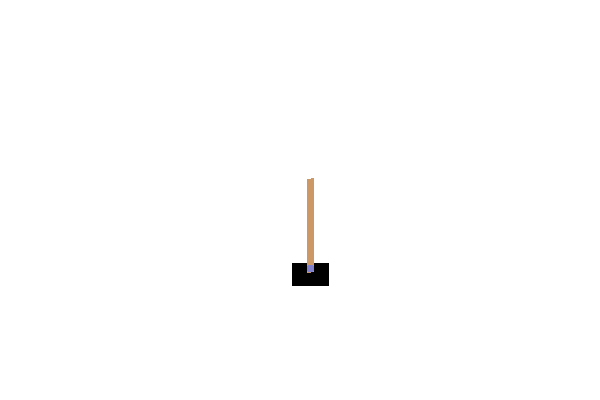
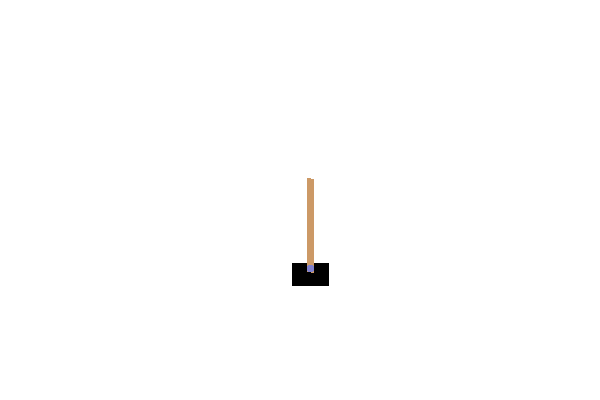
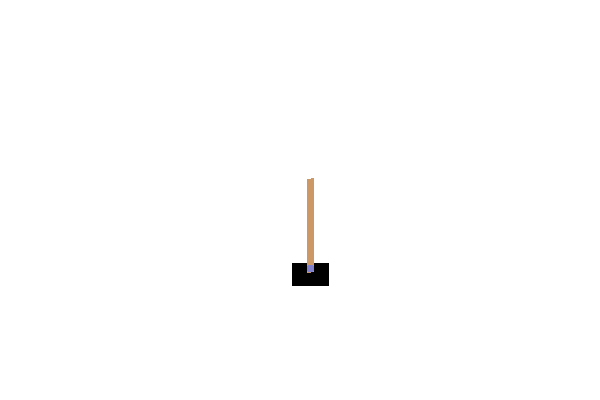
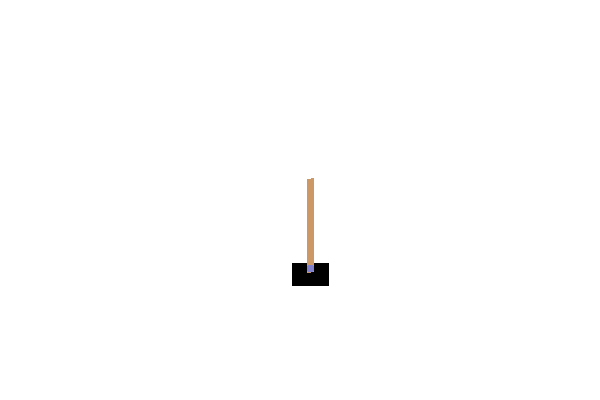
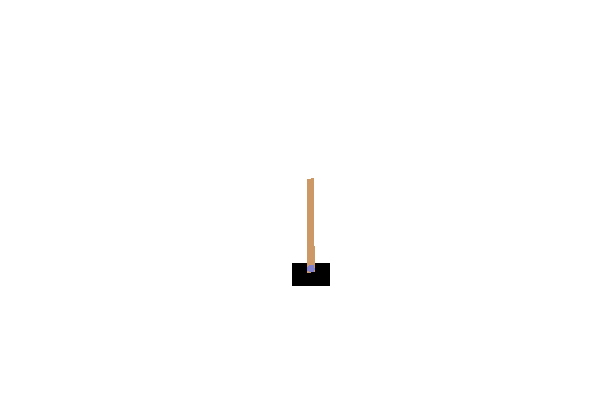

In [9]:
Env2.animation.run()
# Env2.animation.reset()

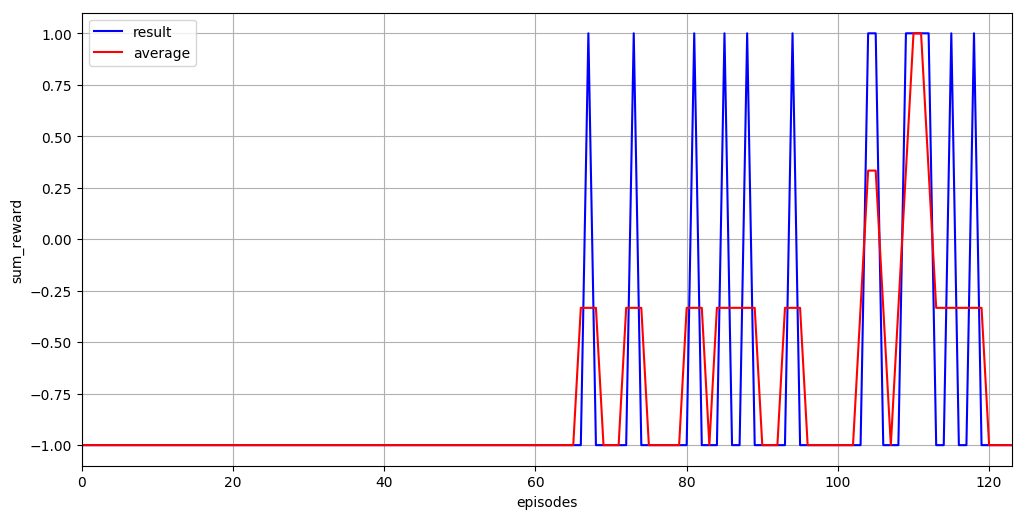

In [10]:
a2c.logger.graph("sum_reward",average_range=1,figsize=(12,6))

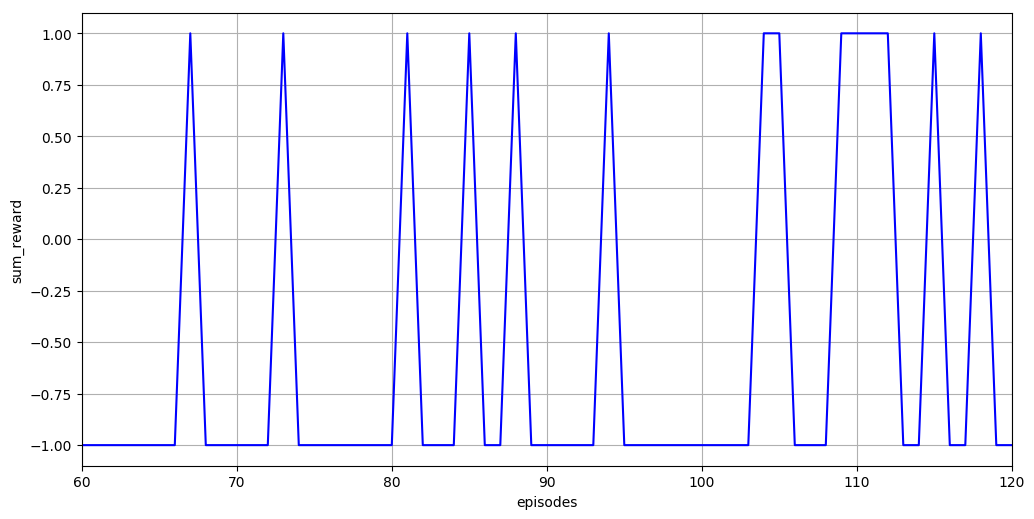

In [11]:
a2c.logger.graph("sum_reward",average_range=0,x_lim=[60,120],figsize=(12,6))